<center><h1>MIMO CSTR Case Study</h1></center>


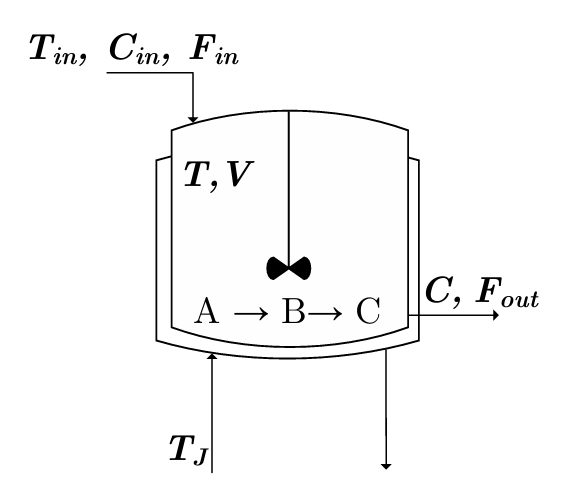

The following generalized reactions take place in the reactor, where B is the desired component 
$$  A \xrightarrow{r_a} B \xrightarrow{r_b} C  $$

We have the following system of ODEs:

$$\frac{dC_A}{dt} = \frac{F_{in}C_{A,in} - F_{out}C_A}{V} - r_a$$

$$ \frac{dC_B}{dt} = r_a - r_b - \frac{F_{out}C_B}{V} $$

$$ \frac{dC_C}{dt} = r_b - \frac{F_{out}C_C}{V} $$

$$ \frac{dT}{dt} = \frac{F_{in}(T_f - T)}{V} + \frac{\Delta H_a}{\rho C_p} r_A + \frac{\Delta H_b}{\rho C_p} r_B + \frac{UA}{V \rho C_p} (T_c - T) $$

$$ \frac{dV}{dt} = F_{in} - F_{out} $$

The three observed states of the reactor are the 1. Concentration of B $C_B$ 2. Reactor Temperature $T$ 3. Volume $V$ => Define the state vector x $x = [C_B, T, V]$

We desire a policy that maps these to the action space, comprising the 1. Cooling jacket temperature $T_c$ 2. Inlet flow rate $F_{in}$ => Define the control vector $u = [T_c, F_{in}]$

This creates a system with two PID controllers:

1. First controller pairs $T_c$ and $C_B$
2. Second controller pairs $F_{in}$ and $V$

The pairing was decided using a Relative Gain Array (RGA). This is additive measurement noise on all states of the CSTR. 

Note*: The PID controllers are not truely independent in a strict sense since the reactor is a coupled, nonlinear system:

* Changes in $T_c$ affects reaction rates, which in turn can influence $C_B$ and even the rate of volume change
* Changing $F_{in}$ affects residence time and concentrations, which can also alter temperature dynamics and thus indirectly affect how the first controller behaves

## Section 1: Model Testing

### Part 1: CSTR Model Dynamics

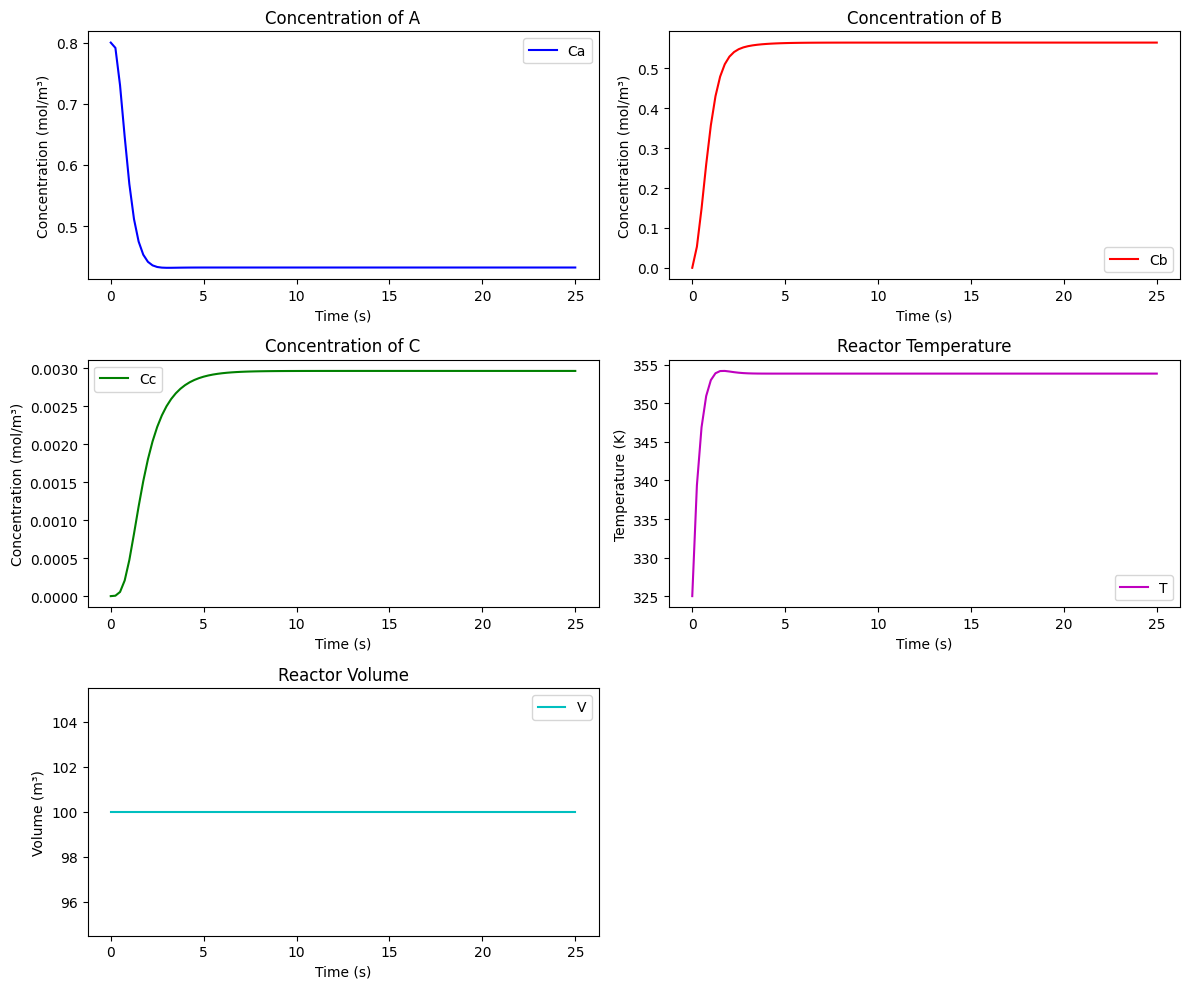

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from CSTR_model_plus import cstr_dynamics

# Define initial conditions and parameters
# State vector: [Ca, Cb, Cc, T, V]
x0 = [0.8, 0.0, 0.0, 325.0, 100.0]

# Control inputs: [Tc, Fin]
u = [350.0, 100.0]

# Feed conditions 
Tf = 350    # Feed temperature (K)
Caf = 1.0   # Feed concentration of A (mol/m^3)

# Define the time span for simulation (e.g., 0 to 100 minutes)
t = np.linspace(0, 25, 101)  # 1001 points => dt=0.1 minute

# Simulate the reactor dynamics using odeint
x = odeint(cstr_dynamics, x0, t, args=(u, Tf, Caf))

# Extract state variables from the simulation result
Ca = x[:, 0]
Cb = x[:, 1]
Cc = x[:, 2]
T  = x[:, 3]
V  = x[:, 4]

# Plot the results
plt.figure(figsize=(12, 10))

plt.subplot(3, 2, 1)
plt.plot(t, Ca, 'b-', label='Ca')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (mol/m³)')
plt.title('Concentration of A')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(t, Cb, 'r-', label='Cb')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (mol/m³)')
plt.title('Concentration of B')
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(t, Cc, 'g-', label='Cc')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (mol/m³)')
plt.title('Concentration of C')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(t, T, 'm-', label='T')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)')
plt.title('Reactor Temperature')
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(t, V, 'c-', label='V')
plt.xlabel('Time (s)')
plt.ylabel('Volume (m³)')
plt.title('Reactor Volume')
plt.legend()

plt.tight_layout()
plt.show()


### Part 2: PID controller test

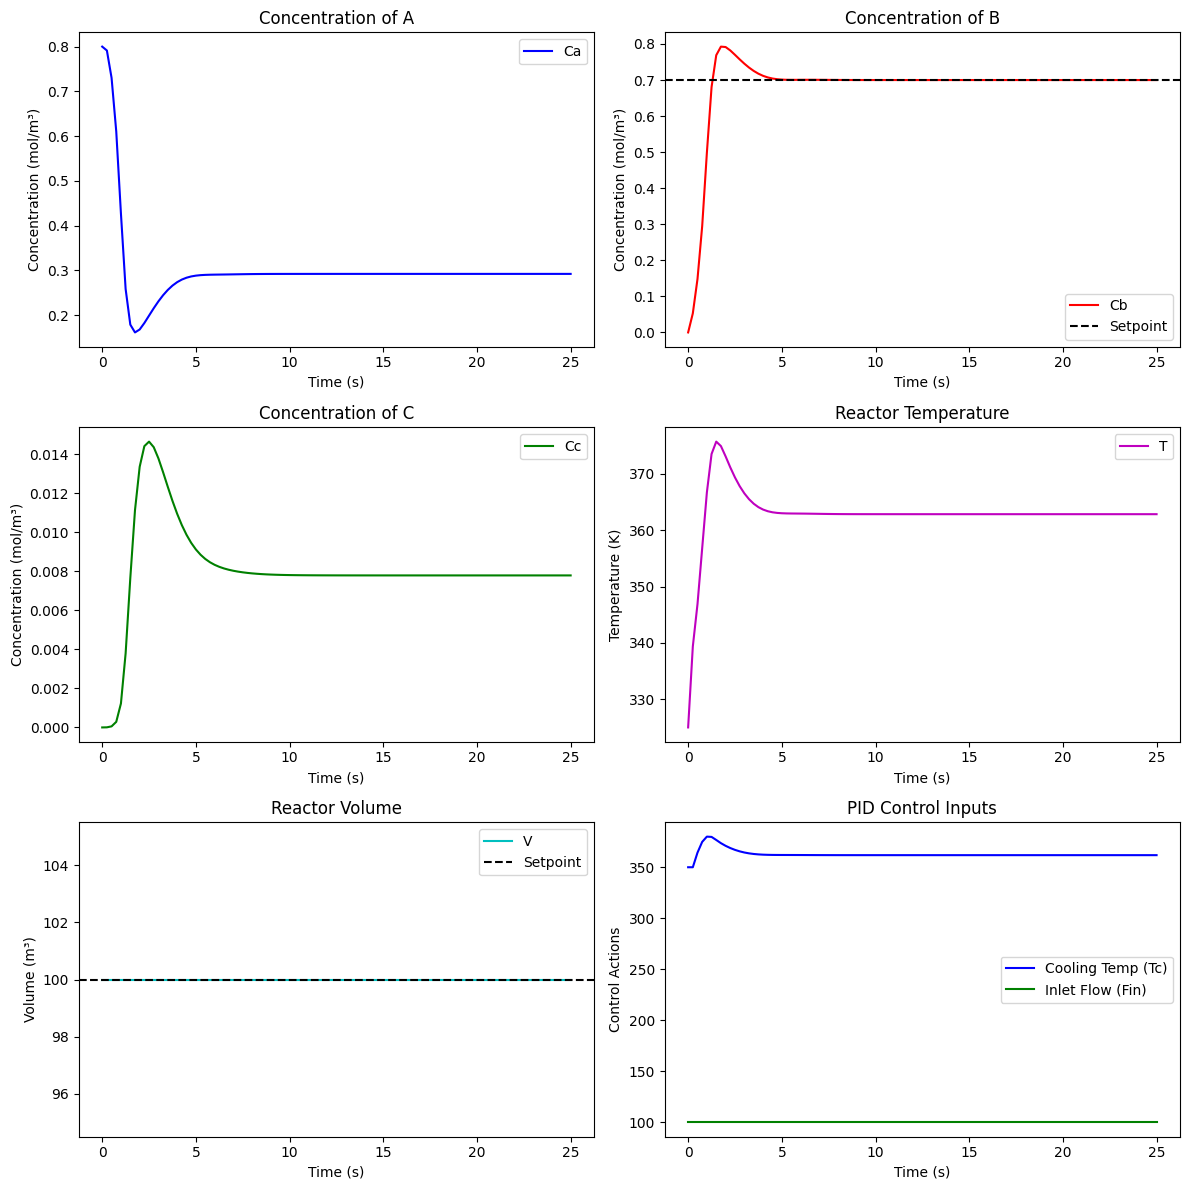

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from CSTR_model_plus import cstr_dynamics, PID_velocity 

# PID Gains 
Kp_Cb, Ki_Cb, Kd_Cb = 3.09, 0.03, 0.83
Kp_V, Ki_V, Kd_V = 0.84, 1.85, 0.08
Ks = [Kp_Cb, Ki_Cb, Kd_Cb, Kp_V, Ki_V, Kd_V]  # Combined gain array

# Initial Conditions
x0 = [0.8, 0.0, 0.0, 325.0, 100.0]  # [Ca, Cb, Cc, T, V]
u0 = [350.0, 100.0]  # Initial control inputs: [Tc, Fin]
Tf, Caf = 350, 1.0  # Feed conditions

# Setpoints
Cb_setpoint = 0.7   # Desired product B concentration
V_setpoint = 100.0  # Desired reactor volume

# Simulation Setup
t = np.linspace(0, 25, 101)  # 25 seconds
dt = t[1] - t[0]  # Time step

# Storage for results
states = np.zeros((len(t), 5))  # State variables
Tc_values, Fin_values = np.zeros(len(t)), np.zeros(len(t))  # Control actions

# PID Error History (needed for velocity PID)
e_history = [np.array([0, 0]), np.array([0, 0])]  # Store at least two previous errors
u_history = [u0, u0]  # Store previous control actions

# Simulation Loop
x = x0
for i in range(len(t)):
    # Store current state
    states[i, :] = x
    
    # Compute current errors for PID (difference from setpoint)
    e_now = np.array([Cb_setpoint - x[1], V_setpoint - x[4]])

    # Compute PID control action using velocity form
    if i < 2:
        control_action = u_history[-1]  
    else:
        control_action = PID_velocity(Ks, e_now, e_history, u_history, dt)

    # Apply physical constraints
    Tc, Fin = np.clip(control_action[0], 290, 450), np.clip(control_action[1], 95, 105)

    # Store control history
    e_history.append(e_now)
    u_history.append([Tc, Fin])
    if len(e_history) > 3:
        e_history.pop(0)
        u_history.pop(0)

    # Apply updated controls
    Tc_values[i], Fin_values[i] = Tc, Fin

    # Simulate next time step
    u = [Tc, Fin]
    x = odeint(cstr_dynamics, x, [0, dt], args=(u, Tf, Caf))[-1]

# Extract states
Ca, Cb, Cc, T, V = states.T

# Plot Results
plt.figure(figsize=(12, 12))

plt.subplot(3, 2, 1)
plt.plot(t, Ca, label='Ca', color='b')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (mol/m³)')
plt.title('Concentration of A')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(t, Cb, label='Cb', color='r')
plt.axhline(y=Cb_setpoint, color='k', linestyle='--', label='Setpoint')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (mol/m³)')
plt.title('Concentration of B')
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(t, Cc, label='Cc', color='g')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (mol/m³)')
plt.title('Concentration of C')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(t, T, label='T', color='m')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)')
plt.title('Reactor Temperature')
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(t, V, label='V', color='c')
plt.axhline(y=V_setpoint, color='k', linestyle='--', label='Setpoint')
plt.xlabel('Time (s)')
plt.ylabel('Volume (m³)')
plt.title('Reactor Volume')
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(t, Tc_values, label='Cooling Temp (Tc)', color='b')
plt.plot(t, Fin_values, label='Inlet Flow (Fin)', color='g')
plt.xlabel('Time (s)')
plt.ylabel('Control Actions')
plt.title('PID Control Inputs')
plt.legend()

plt.tight_layout()
plt.show()


### Part 3: Setpoint Tracking Problem

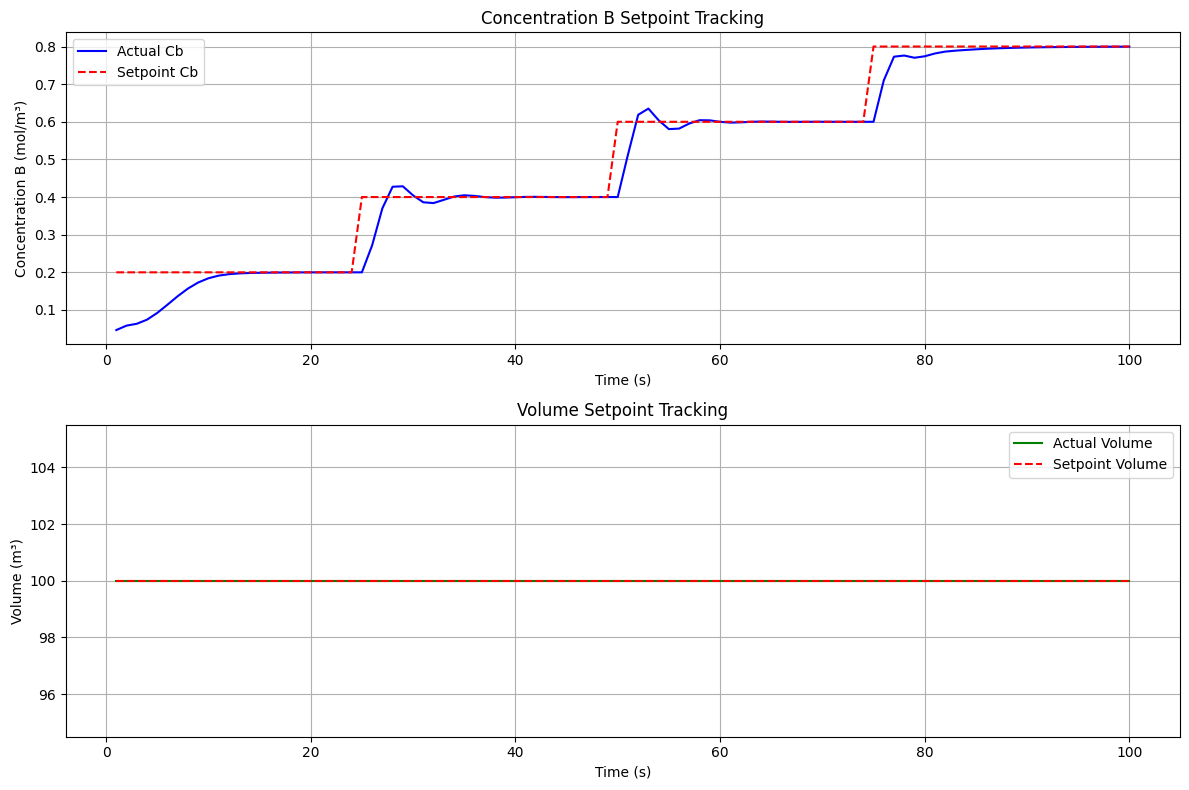

Simulation completed with setpoint tracking


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from CSTR_model_plus import CSTRRLEnv, PID_velocity

def main():
    # Create environment with setpoint tracking
    env = CSTRRLEnv(
        simulation_steps=100,
        dt = 1.0,
        uncertainty_level=0.0,
        noise_level=0.0,
        transport_delay_steps=0,
        actuator_delay_steps=0,
        enable_disturbances=False
    )

    # Define setpoints for tracking
    setpoints_Cb  = [0.2, 0.4, 0.6, 0.8]  # Concentration B setpoints
    setpoints_V   = [100, 100, 100, 100]  # Volume setpoints
    setpoint_durations = [25, 25, 25, 25] # 25 timesteps per setpoint

    # Reset environment with custom setpoints
    obs, _ = env.reset(options={
        'setpoints_Cb': setpoints_Cb,
        'setpoints_V': setpoints_V,
        'setpoint_durations': setpoint_durations
    })

    # Fixed PID gains for this example
    fixed_pid_gains = np.array([25., 0.7791, 0.0200, 0.7432, 0.7561, 0.0977])
    
    action = np.zeros(6) # Normalized action spaces [-1, 1]

    # Convert fixed gains to normalized action space
    action = 2.0 * (fixed_pid_gains - env.pid_lower) / (env.pid_upper - env.pid_lower) - 1.0

    # Run simulation with fixed controller
    done = False
    rewards = []
    cb_values = [] 
    cb_setpoints = []
    v_values = []
    v_setpoints = []
    time_values = []

    while not done:
        # Take a step with fixed PID controller
        obs, reward, done, _, info = env.step(action)

        # Store data for plotting
        rewards.append(reward)
        cb_values.append(info['true_state'][1])  # Concentration B
        cb_setpoints.append(info['setpoint_Cb'])
        v_values.append(info['true_state'][4])   # Volume
        v_setpoints.append(info['setpoint_V'])
        time_values.append(len(cb_values))
        
        # # Render the current state
        # env.render()

    # Plot results after simulation
    plt.figure(figsize=(12, 8))
    
    # Plot Concentration B
    plt.subplot(2, 1, 1)
    plt.plot(time_values, cb_values, 'b-', label='Actual Cb')
    plt.plot(time_values, cb_setpoints, 'r--', label='Setpoint Cb')
    plt.legend()
    plt.title('Concentration B Setpoint Tracking')
    plt.xlabel('Time (s)')
    plt.ylabel('Concentration B (mol/m³)')
    plt.grid(True)
    
    # Plot Volume
    plt.subplot(2, 1, 2)
    plt.plot(time_values, v_values, 'g-', label='Actual Volume')
    plt.plot(time_values, v_setpoints, 'r--', label='Setpoint Volume')
    plt.legend()
    plt.title('Volume Setpoint Tracking')
    plt.xlabel('Time (s)')
    plt.ylabel('Volume (m³)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

    # Clean up
    env.close()

    print("Simulation completed with setpoint tracking")

if __name__ == "__main__":
    main()

## Section 2: PID Controllers Parameter Tuning

### Part 1: Static PID Gain Approach

This approach optimizes the static PID gains for the CSTR control system using differential evolution. The goal is to find optimal PID gains that minimize error when tracking a setpoint schedule. 

In [5]:
from static_pid_gain import StaticPIDOptimizer, run_optimization

if __name__ == "__main__":
    from CSTR_model_plus import CSTRRLEnv

    # Create environment with minimal noise/disturbance/noise for optimization
    env = CSTRRLEnv(
        simulation_steps=25*5,
        dt=1.0,
        uncertainty_level=0.0,     # No uncertainty
        noise_level=0.0,           # No measurement noise
        actuator_delay_steps=0,    # No actuator delay
        transport_delay_steps=0,   # No transport delay
        enable_disturbances=False  # No disturbances
    )

    # Run optimization
    optimal_gains = run_optimization(env, maxiter=30, popsize=15)

    print("Optimization complete.")

Starting optimization with 30 iterations and population size 15
differential_evolution step 1: f(x)= 0.2704660026152467
differential_evolution step 2: f(x)= 0.2704660026152467
differential_evolution step 3: f(x)= 0.2704660026152467
differential_evolution step 4: f(x)= 0.2668539916176404
differential_evolution step 5: f(x)= 0.2668539916176404
differential_evolution step 6: f(x)= 0.2668539916176404
differential_evolution step 7: f(x)= 0.2668539916176404
differential_evolution step 8: f(x)= 0.23560541783271693
differential_evolution step 9: f(x)= 0.23560541783271693
differential_evolution step 10: f(x)= 0.23560541783271693
differential_evolution step 11: f(x)= 0.23560541783271693
differential_evolution step 12: f(x)= 0.23560541783271693
differential_evolution step 13: f(x)= 0.23560541783271693
differential_evolution step 14: f(x)= 0.23560541783271693
differential_evolution step 15: f(x)= 0.23383905440634237
differential_evolution step 16: f(x)= 0.23383905440634237
differential_evolution s

Loaded data from ./results/optimal_pid_gains.npy:
 [2.50000000e+01 7.32644787e-01 2.00000000e-02 3.53409552e-01
 2.58712863e-01 2.72371291e-01]


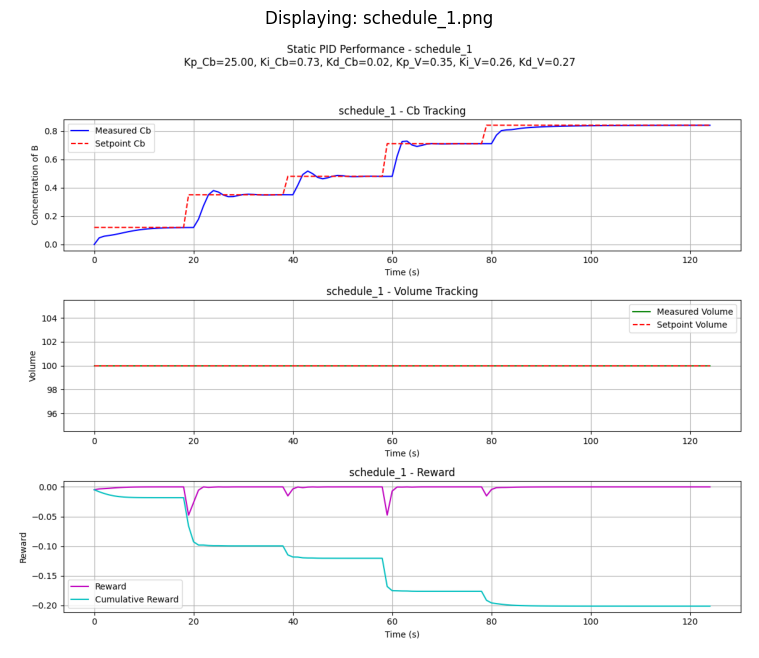

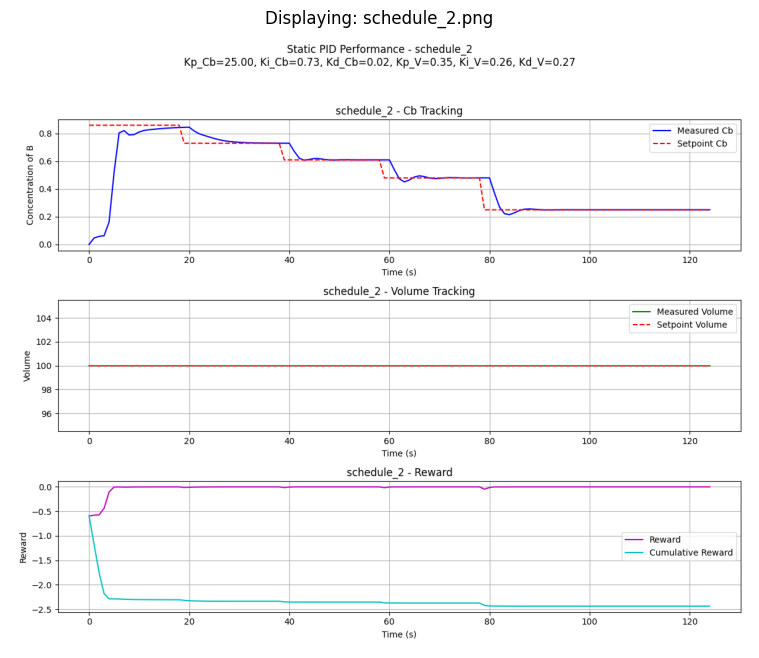

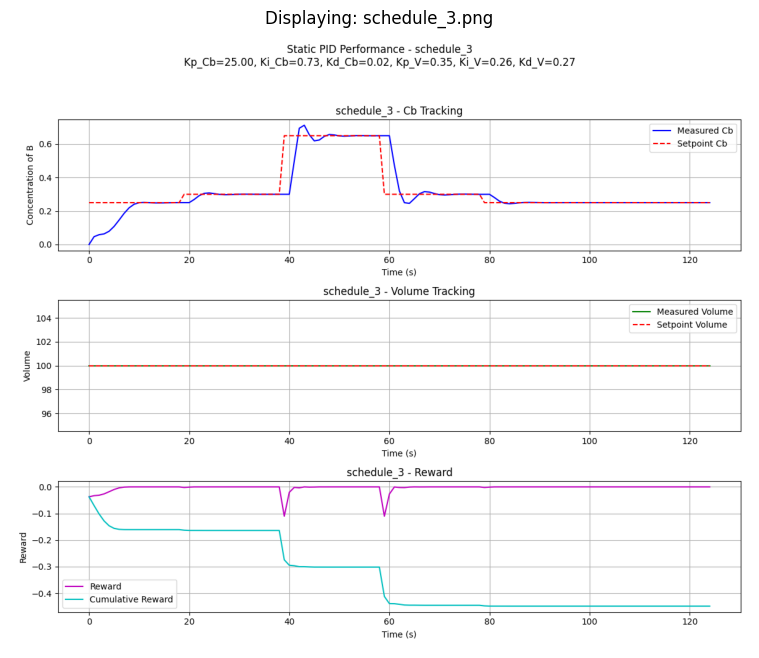

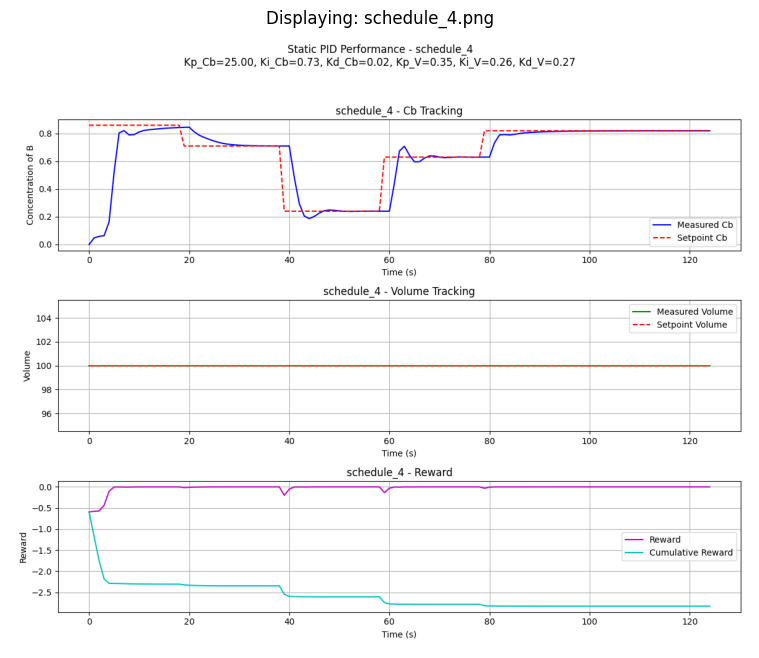

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os

def load_npy_file(npy_path):
    if os.path.exists(npy_path):
        data = np.load(npy_path)
        print(f"Loaded data from {npy_path}:\n", data)
        return data
    else:
        print(f"Error: File {npy_path} not found")
        return None
    
def display_png_file(png_path):
    if os.path.exists(png_path):
        img = plt.imread(png_path)
        plt.figure(figsize=(12,8))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Displaying: {os.path.basename(png_path)}")
        plt.show()
    else:
        print(f"Eror: File {png_path} not found.")

if __name__ == "__main__":
    npy_file_path = "./results/optimal_pid_gains.npy"
    load_npy_file(npy_file_path)
    for i in range(4):
        png_file_path = f"./results/plots/schedule_{i+1}.png"
        display_png_file(png_file_path) 
        


### Part 2: Adaptive PID Control (Conventional Approach)



## Section 3. Reinforcement Learning for Dynamic Tuning of PID Controllers

### Part 0: Historical (Simulation) Data Generation

Key Assumptions:

1. In real-world chemical process industries, before a plant is built, extensive modeling, design, and simulations are conducted

Conclusion from 1: If the plant is well-designed and commisioned, then a reasonably accurate model exists. However, uncertainties and disturbances (e.g., catalyst deactivation, equipment aging) always exist, which is why adaptive control and RL-based tuning can be useful.

2. If a reliable model exists, we can use it to simulate vast amounts of data before applying RL in real plant. Advantages: 
    * Safe exploration -- RL does not need to interact with the real plant, avoiding unsafe operations. 
    * Large-scale data generation -- We can simulate disturbances, different setpoints, and failure modes to cover a wide range of scenarios.
    * Better Generalization -- The RL agent can learn from highly diverse training data rather than being constrained by limited real-world trials.
    * Efficient Deployment -- Once trained on simulated data, the RL-based PID tuning model can be fine-tuned online with minimal interaction. 


Additional Comments on the offline dataset

* Essential Data for Offline RL:
    * Transitions: (state, action, reward, next_state, done) tuples
    * Metadata: Actual PID gains, setpoints, and any relevant simulation parameters
    * Coverage: The dataset should span nominal operating conditions, disturbances, and various setpoint transitions to train an RL agent robustly

* Plots:
    * Episode Reward Curves: To visualize performance over time
    * Action Distribtions: To verify that the exploration strategy covers a wide range of actions
    * State vs. Setpoint Trajectories: To ensure that the data reflects diverse tracking behaviors
    * Summary Statics: Such as means and variances of key variables to provide an overall view of data diversity

* Range of Spectrum:
    * Dataset includes episodes under normal operation, under disturbances, and with different setpoint profiles (increasing, decreasing, peak, valley, constant). => This helps the offline RL algorithm learn a robust policy that generalizes across operating conditions


In [1]:
from gen_sim_data import generate_diverse_dataset, DataGenerator

if __name__ == "__main__":
    from CSTR_model_plus import CSTRRLEnv
    
    # Create environment with realistic conditions
    env = CSTRRLEnv(
        simulation_steps=120,
        dt=1.0,
        uncertainty_level=0.00,     # Add some uncertainty for realism
        noise_level=0.00,           # Add some noise for realism
        actuator_delay_steps=0,     # Add realistic delays
        transport_delay_steps=0,
        enable_disturbances=False   # Enable disturbances for robustness
    )
    
    # Generate dataset with default parameters
    dataset = generate_diverse_dataset(env, n_episodes=20)
    
    print("Dataset generation complete.")

Generating diverse dataset with 20 total episodes
Generating 10 episodes with 'static_pid' strategy


100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


Generated dataset with 1200 transitions from 10 episodes
Generating 10 episodes with 'decaying' strategy


100%|██████████| 10/10 [00:01<00:00,  7.07it/s]


Generated dataset with 1200 transitions from 10 episodes
Combined 2 datasets with a total of 2400 transitions
Dataset contains 2400 transitions from 20 episodes
Reward statistics:
  Mean: -0.0979
  Std: 0.1207
  Min: -0.6070
  Max: -0.0000
Action statistics:
  Action 0 - Mean: 25.0077, Std: 0.4806
  Action 1 - Mean: 0.7409, Std: 0.4481
  Action 2 - Mean: 0.0269, Std: 0.4463
  Action 3 - Mean: 0.3467, Std: 0.4571
  Action 4 - Mean: 0.2529, Std: 0.4706
  Action 5 - Mean: 0.2735, Std: 0.4553
PID gains statistics:
  Kp_Cb - Mean: 385.1161, Std: 7.2096
  Ki_Cb - Mean: 17.4089, Std: 4.4815
  Kd_Cb - Mean: 5.1444, Std: 2.2272
  Kp_V - Mean: 0.6733, Std: 0.2286
  Ki_V - Mean: 1.2529, Std: 0.4706
  Kd_V - Mean: 0.6404, Std: 0.2254
Unique Cb setpoints: [0.6        0.61742508 0.62       0.63       0.64679836 0.64680559
 0.65       0.66       0.7        0.71       0.71236204 0.72
 0.73       0.75       0.76       0.77959755 0.7803345  0.8
 0.81       0.81242177 0.81959818 0.82       0.83       0.8

In [2]:
import pickle

def print_dataset(file_path):
    with open(file_path, 'rb') as file:
        dataset = pickle.load(file)
    
    for key, value in dataset.items():
        print(f"{key}: {value}")

# Specify the file path
file_path = '/home/jzhao/work/nonlinear-multi-loop-CSTR-for-RL/offline_data/cstr_diverse_dataset.pkl'

# Print the dataset
print_dataset(file_path)

states: [[0.00000000e+00 3.25000000e+02 1.00000000e+02 ... 1.00000000e+02
  6.00000000e-01 1.00000000e+02]
 [0.00000000e+00 3.25000000e+02 1.00000000e+02 ... 1.00000000e+02
  6.00000000e-01 1.00000000e+02]
 [4.66206757e-02 3.17018712e+02 1.00000000e+02 ... 1.00000000e+02
  6.00000000e-01 1.00000000e+02]
 ...
 [3.66082240e-01 3.15119888e+02 1.00000000e+02 ... 1.00000000e+02
  7.20000000e-01 1.00000000e+02]
 [7.62241621e-01 4.22668361e+02 1.00000000e+02 ... 1.00000000e+02
  7.20000000e-01 1.00000000e+02]
 [3.66082240e-01 3.15119888e+02 1.00000000e+02 ... 1.00000000e+02
  7.20000000e-01 1.00000000e+02]]
actions: [[ 2.51621218e+01  8.02646823e-01  1.06871072e-01  3.22762614e-01
   4.71530695e-01  2.13829246e-01]
 [ 2.47654755e+01  6.44995357e-01 -1.63224271e-02  5.77158693e-01
   2.10041390e-01  2.77104723e-01]
 [ 2.52093208e+01  9.98122607e-01 -6.54275896e-02  3.76307980e-01
   1.90624169e-01  1.07129911e-01]
 ...
 [ 2.47998749e+01  7.01077034e-01  4.50395906e-01  2.13499120e-01
   2.8827

### Part 1: Particle Swarm Optimizer (PSO) + Control-Informed RL (CIRL)

* The Particle Swarm Optimization (PSO) algorithm is an optimization technique inspured by the collective behavior in flocks of birds or schools of fish. As an evolutionary algorithm, PSO mimics the way individuals (particles) in a group evolve their positions to collectively find an optimal solution. 

    In PSO:
    * Each particle represents a potential solution to the problem
    * Particles move through the solution space, guided by their own best-known position and the best-known position of their neighbors or the entire swarm
    * Over time, particle "evolve" by updating their positions and velocities, balancing exploration (searching new areas) and exploitation (focusing on promising areas).

This evolutionary process shares similarities with other EAs like genetic algorithms, in that it involves iteration and optimization based on a population of solutions, but it doesn't involve genetic operators like crossover or mutation. Instead, it focuses on social interaction and learning.

**CIRL Rollout**:

**Input:** Policy Parameters $ \theta $, Number of simulation timesteps $ n_s $, Discrete time environment $ f $  
**Output:** Cumulative Reward $ R $

1. $ s \gets s_0 $  # Reset observation to initial state  
2. $ R \gets 0 $  # Initialize cumulative reward  
3. **for** $ t = 0 $ **to** $ n_s - 1 $:  
    1. $ K_{p,t}, \tau_{i,t}, \tau_{d,t} \gets \pi_\theta(s_t) $  # Get current PID gains from policy  
    2. $ u_t \gets PID(K_{p,t}, \tau_{i,t}, \tau_{d,t}, e_t, e_{t-1}, e_{t-2}) $  # Use PID controller to output control input  
    3. $ x_{t+1}, r_t \gets f(u_t, x_t) $  # Take one timestep in the environment  
    4. $ s_{t+1} \gets [x_{t+1}, x_t, x^*_{t+1}] $  # Update observation vector  
    5. $ R \gets R + r_t $  
4. **return** $ R $  # Return cumulative reward


**Overall Process**

1. Initialization with PSO: Use PSO to find good initial policy parameters
2. Offline RL training: Fine-tune using the generated dataset
3. Online Adaptation: Further refine the policy with direct environment interaction
4. Evalaution: Compare performance against the baseline static PID approach


Loaded dataset from /home/jzhao/work/nonlinear-multi-loop-CSTR-for-RL/offline_data/cstr_diverse_dataset.pkl with 2400 transitions
Starting supervised learning phase...
Loaded 2400 transitions into replay buffer (capacity: 3400)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 30/30 | Loss: 96.904326: 100%|██████████| 30/30 [00:00<00:00, 33.52it/s]


Supervised learning completed. Final model saved to ./results/CIRL/models/cirl_policy_supervised.pt


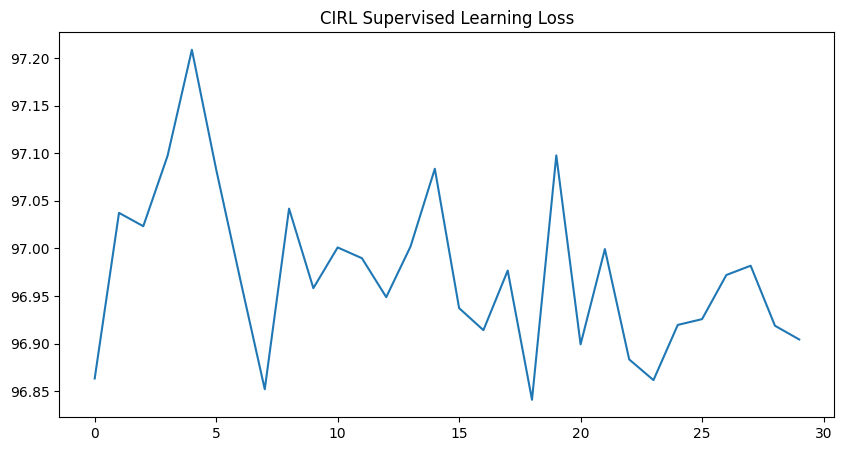

Starting PSO optimization phase...


  0%|          | 0/50 [00:00<?, ?it/s]

  Schedule 1: -18.0214
  Schedule 2: -22.9881
  Schedule 3: -19.7877
  Schedule 4: -29.6009


Iteration 10/50 | Best: -2.1922 | Mean: -11.2659:  20%|██        | 10/50 [03:41<14:03, 21.09s/it]

  Schedule 1: -7.0286
  Schedule 2: -6.8034
  Schedule 3: -9.7348
  Schedule 4: -15.4972


Iteration 20/50 | Best: -2.0867 | Mean: -10.0916:  40%|████      | 20/50 [07:12<10:33, 21.13s/it]

  Schedule 1: -4.4924
  Schedule 2: -7.4029
  Schedule 3: -5.8635
  Schedule 4: -10.3703


Iteration 30/50 | Best: -2.0451 | Mean: -8.1970:  60%|██████    | 30/50 [10:42<07:01, 21.09s/it] 

  Schedule 1: -17.3874
  Schedule 2: -22.2954
  Schedule 3: -19.1480
  Schedule 4: -28.7560


Iteration 40/50 | Best: -2.0451 | Mean: -6.9598:  80%|████████  | 40/50 [14:09<03:25, 20.59s/it]

  Schedule 1: -1.1793
  Schedule 2: -6.3928
  Schedule 3: -2.3400
  Schedule 4: -15.4277


Iteration 50/50 | Best: -2.0267 | Mean: -8.4379: 100%|██████████| 50/50 [17:34<00:00, 21.09s/it]

PSO optimization completed. Final model saved to ./results/CIRL/models/cirl_policy_pso.pt
Best score: -2.0267


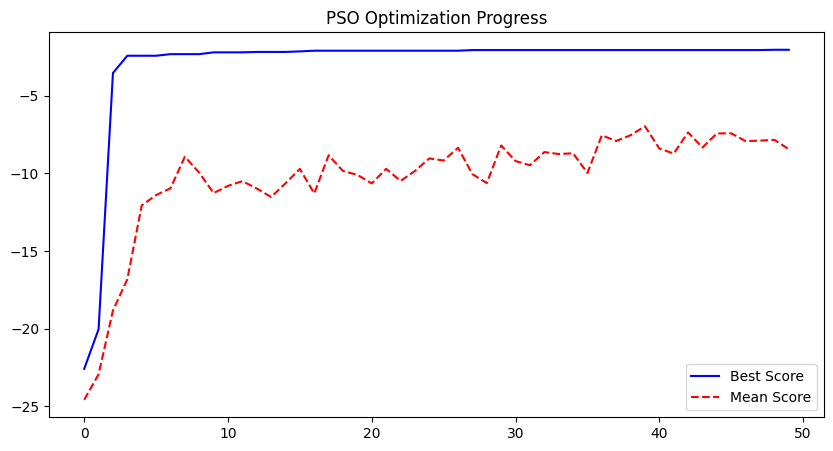


Evaluating on Increasing schedule: [0.6, 0.75, 0.9]
  Episode 1: Reward = -1.23, MSE Cb = 0.009089, MSE V = 0.000000
  Episode 2: Reward = -1.23, MSE Cb = 0.009089, MSE V = 0.000000
  Episode 3: Reward = -1.23, MSE Cb = 0.009089, MSE V = 0.000000
  Schedule Increasing results:
    Mean reward: -1.23
    Mean MSE Cb: 0.009089
    Mean MSE V: 0.000000

Evaluating on Decreasing schedule: [0.9, 0.75, 0.6]
  Episode 1: Reward = -2.68, MSE Cb = 0.019854, MSE V = 0.000000
  Episode 2: Reward = -2.68, MSE Cb = 0.019854, MSE V = 0.000000
  Episode 3: Reward = -2.68, MSE Cb = 0.019854, MSE V = 0.000000
  Schedule Decreasing results:
    Mean reward: -2.68
    Mean MSE Cb: 0.019854
    Mean MSE V: 0.000000

Evaluating on Peak schedule: [0.6, 0.9, 0.6]
  Episode 1: Reward = -1.85, MSE Cb = 0.013695, MSE V = 0.000000
  Episode 2: Reward = -1.85, MSE Cb = 0.013695, MSE V = 0.000000
  Episode 3: Reward = -1.85, MSE Cb = 0.013695, MSE V = 0.000000
  Schedule Peak results:
    Mean reward: -1.85
    M

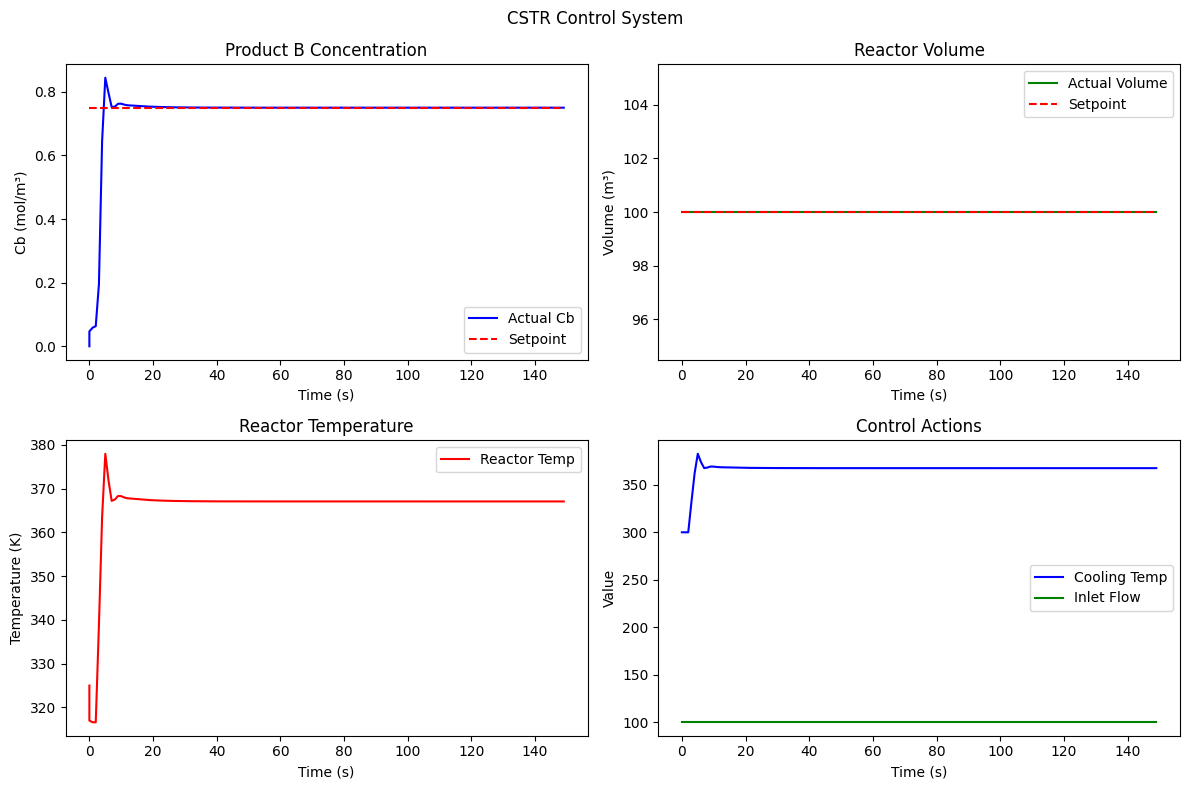

In [7]:
from Train_PSO_CIRL import CIRLTrainer, set_seed

if __name__ == "__main__":
    # Create environment with minimal noise/disturbance
    env = CSTRRLEnv(
        simulation_steps=150,
        dt=1.0,
        uncertainty_level=0.0,     # No uncertainty
        noise_level=0.0,           # No measurement noise
        actuator_delay_steps=0,    # No actuator delay
        transport_delay_steps=0,   # No transport delay
        enable_disturbances=False  # No disturbances
    )
    
    # Set random seed for reproducibility
    set_seed(42)
    
    # Create trainer
    trainer = CIRLTrainer(env, save_dir="./results/CIRL")
    
    # Train policy
    # Load dataset
    dataset = trainer.load_offline_dataset(
        file_path="/home/jzhao/work/nonlinear-multi-loop-CSTR-for-RL/offline_data/cstr_diverse_dataset.pkl"
    )

    # Create policy network
    policy = trainer.create_policy_network(hidden_dims=[128, 128])

    # Supervised learning phase
    supervised_stats = trainer.train_supervised(
        policy=policy,
        dataset=dataset,
        n_epochs=30,
        batch_size=256
    )

    # Plot supervised learning curve
    plt.figure(figsize=(10, 5))
    plt.plot(supervised_stats['epochs'], supervised_stats['mean_losses'])
    plt.title("CIRL Supervised Learning Loss")
    plt.show()

    # PSO optimization phase
    best_policy, pso_history = trainer.train_pso(
        policy_template=policy,
        n_iterations=50,
        num_particles=50
    )

    # Plot PSO learning curve
    plt.figure(figsize=(10, 5))
    plt.plot(pso_history['iterations'], pso_history['best_scores'], 'b-', label='Best Score')
    plt.plot(pso_history['iterations'], pso_history['mean_scores'], 'r--', label='Mean Score')
    plt.title("PSO Optimization Progress")
    plt.legend()
    plt.show()

    # Evaluate the trained policy
    eval_results = trainer.evaluate_policy(
        policy=best_policy,
        n_episodes=3,
        render=True
    )

Evaluating on Increasing schedule: [0.6, 0.75, 0.8]
  Reward: -1.15, MSE Cb: 0.008504, MSE V: 0.000000
Evaluating on Decreasing schedule: [0.8, 0.75, 0.6]
  Reward: -2.03, MSE Cb: 0.015065, MSE V: 0.000000
Evaluating on Peak schedule: [0.7, 0.8, 0.7]
  Reward: -1.56, MSE Cb: 0.011573, MSE V: 0.000000
Evaluating on Valley schedule: [0.8, 0.7, 0.8]
  Reward: -2.03, MSE Cb: 0.015061, MSE V: 0.000000


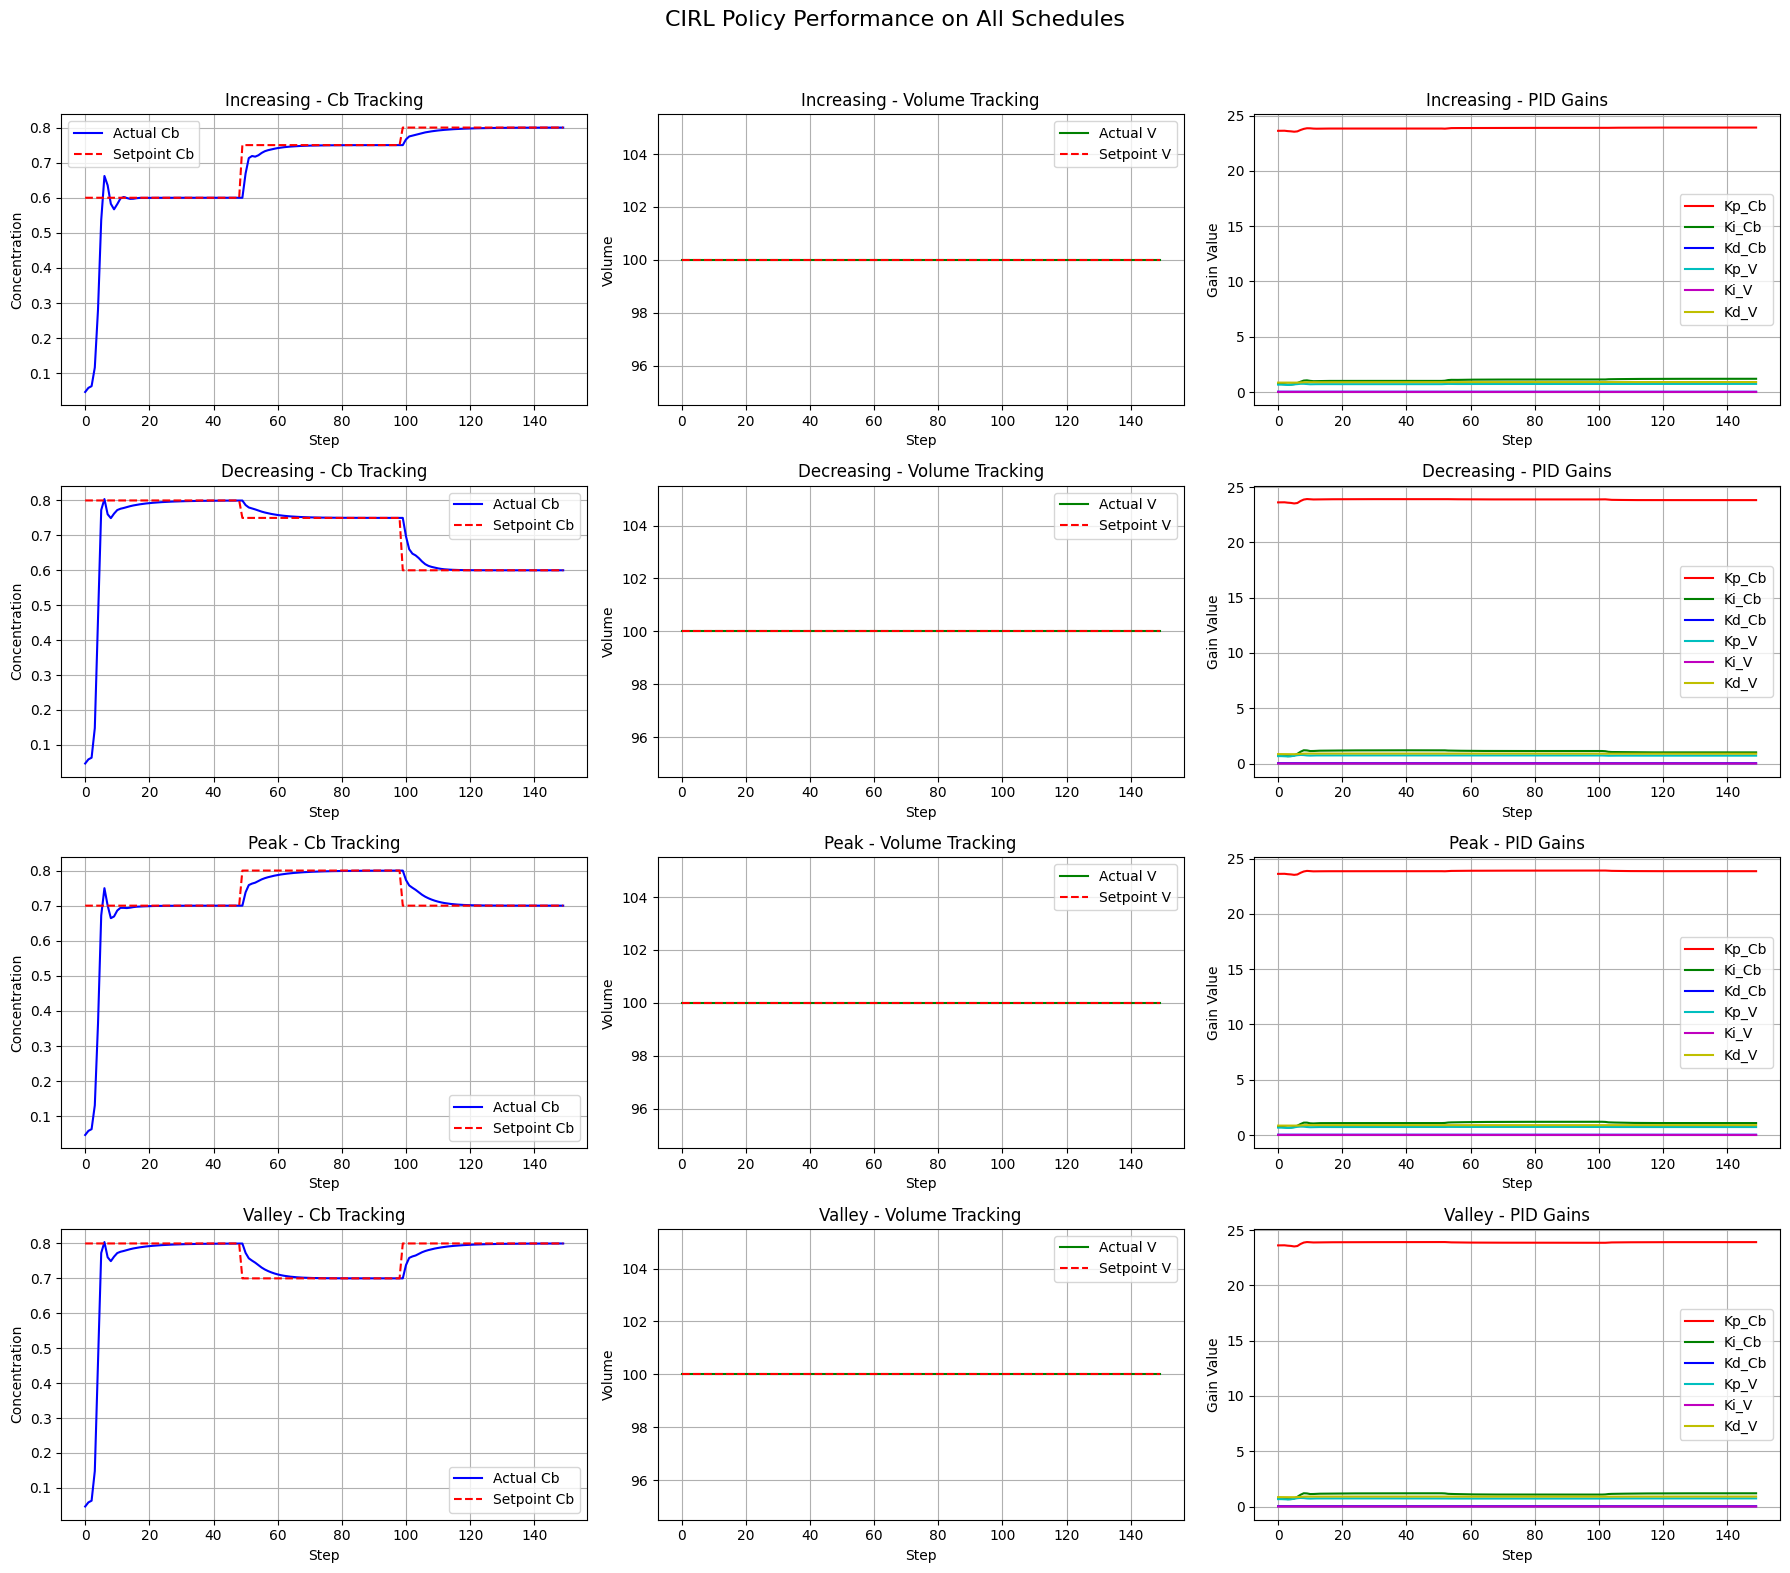

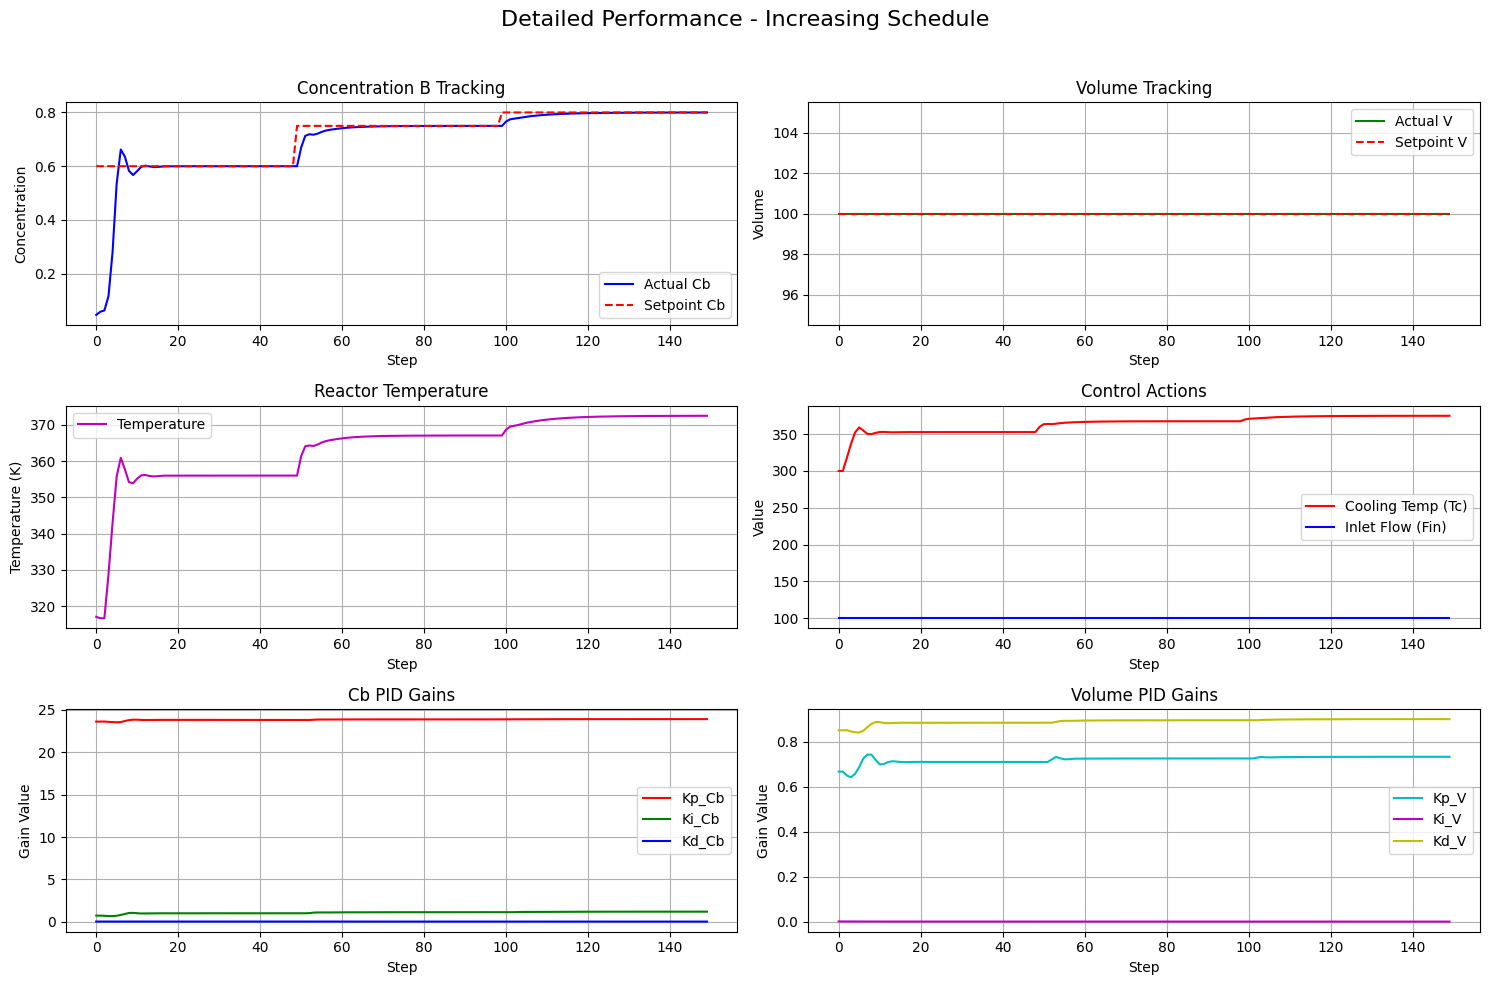

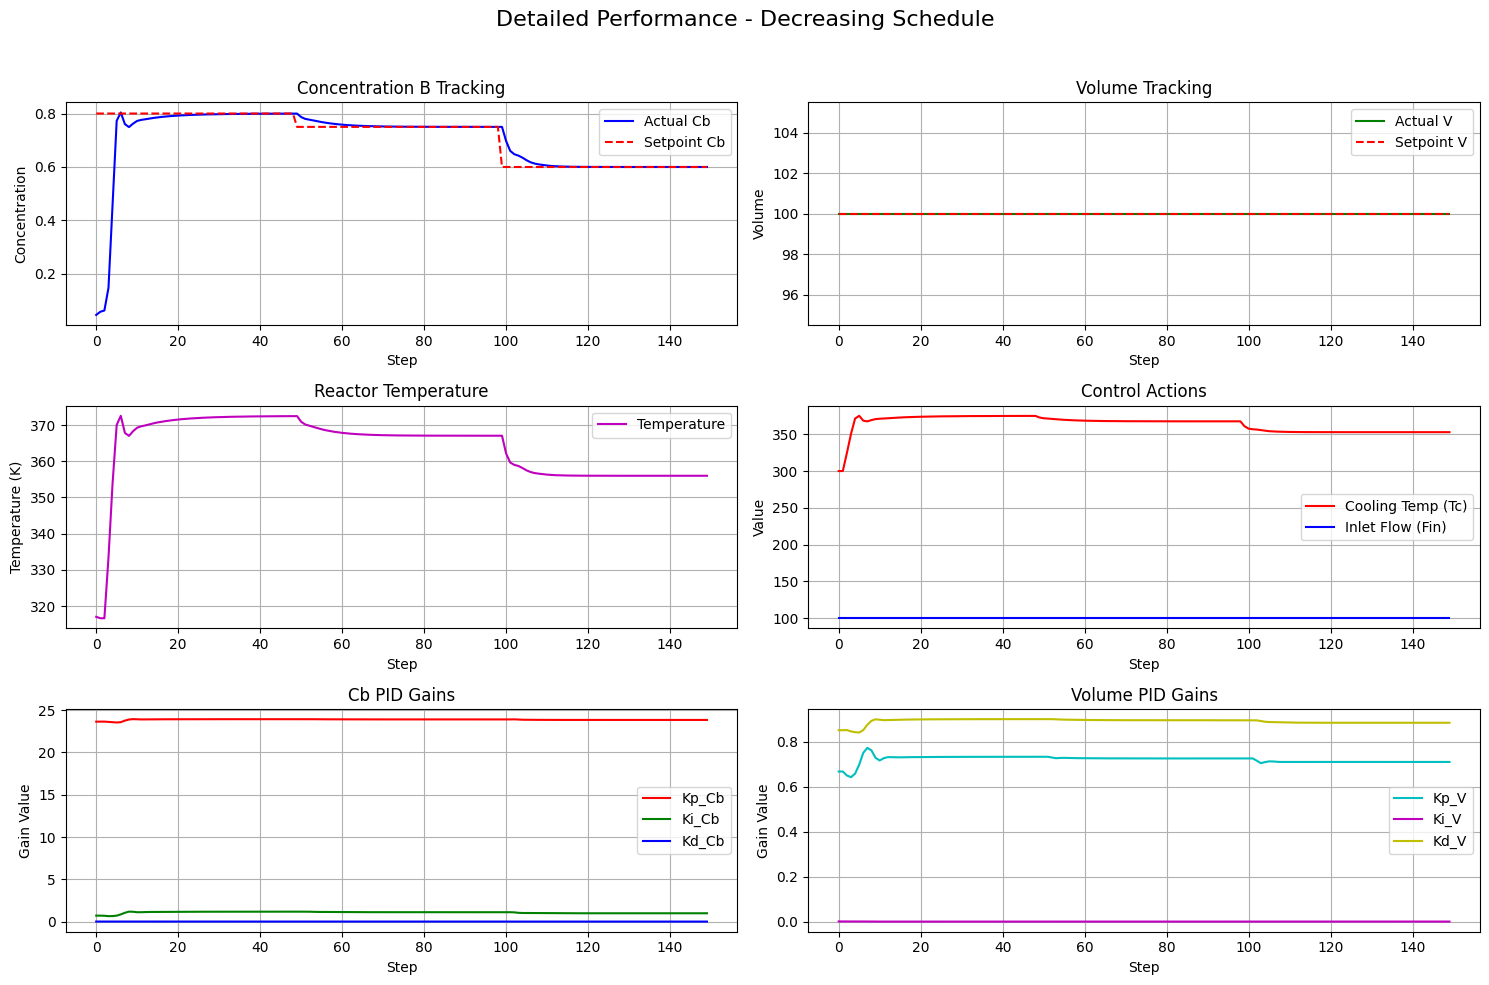

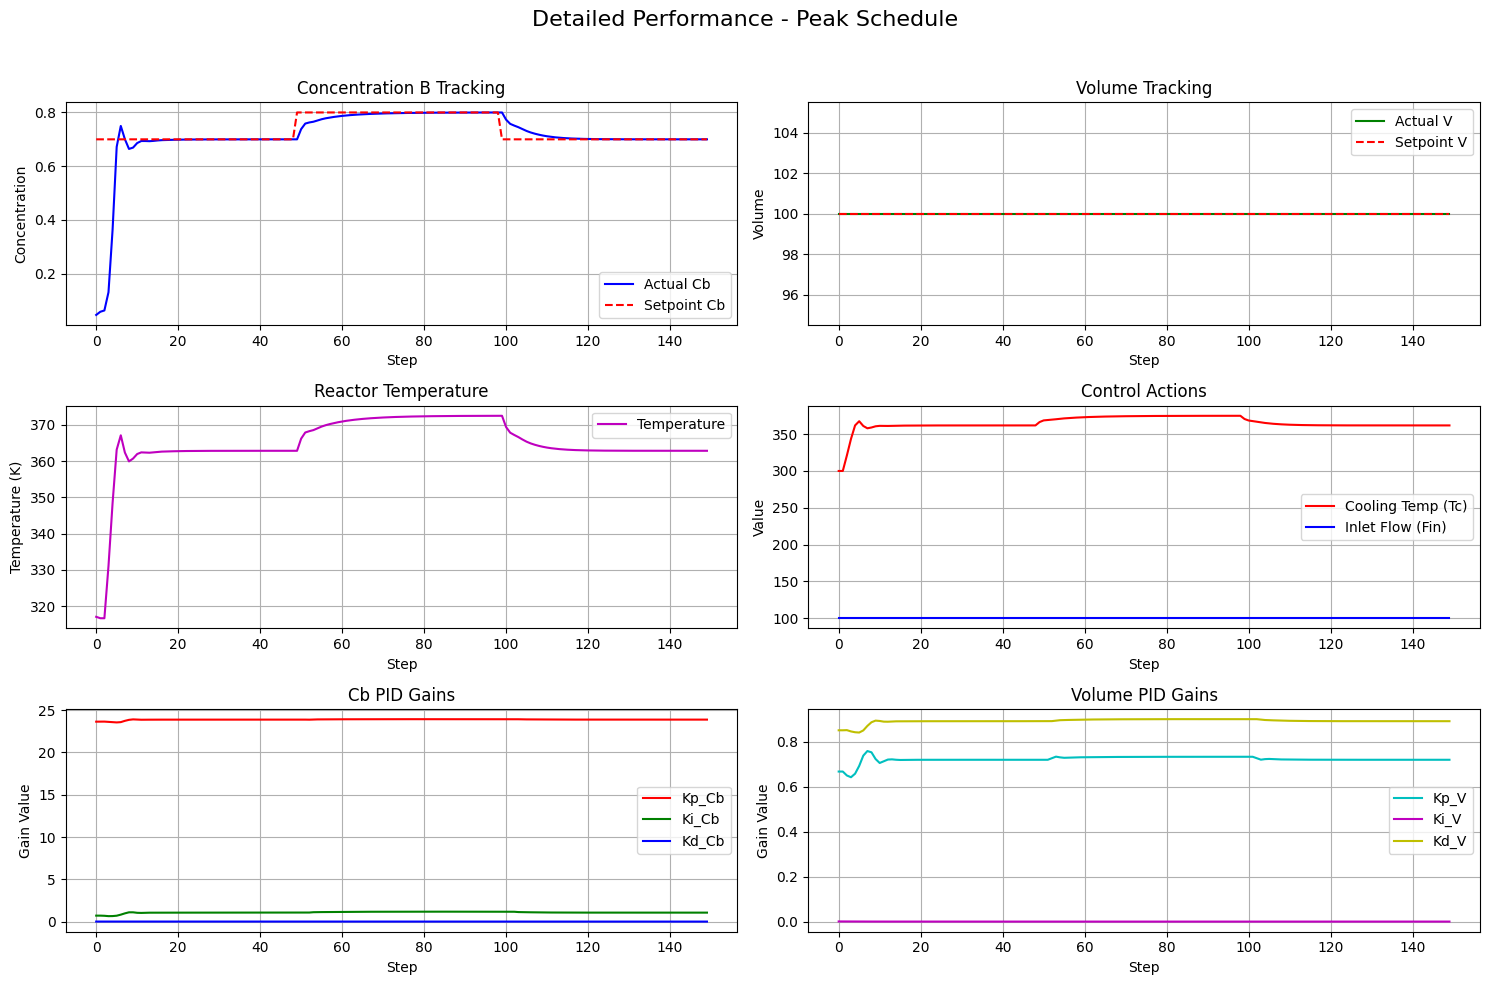

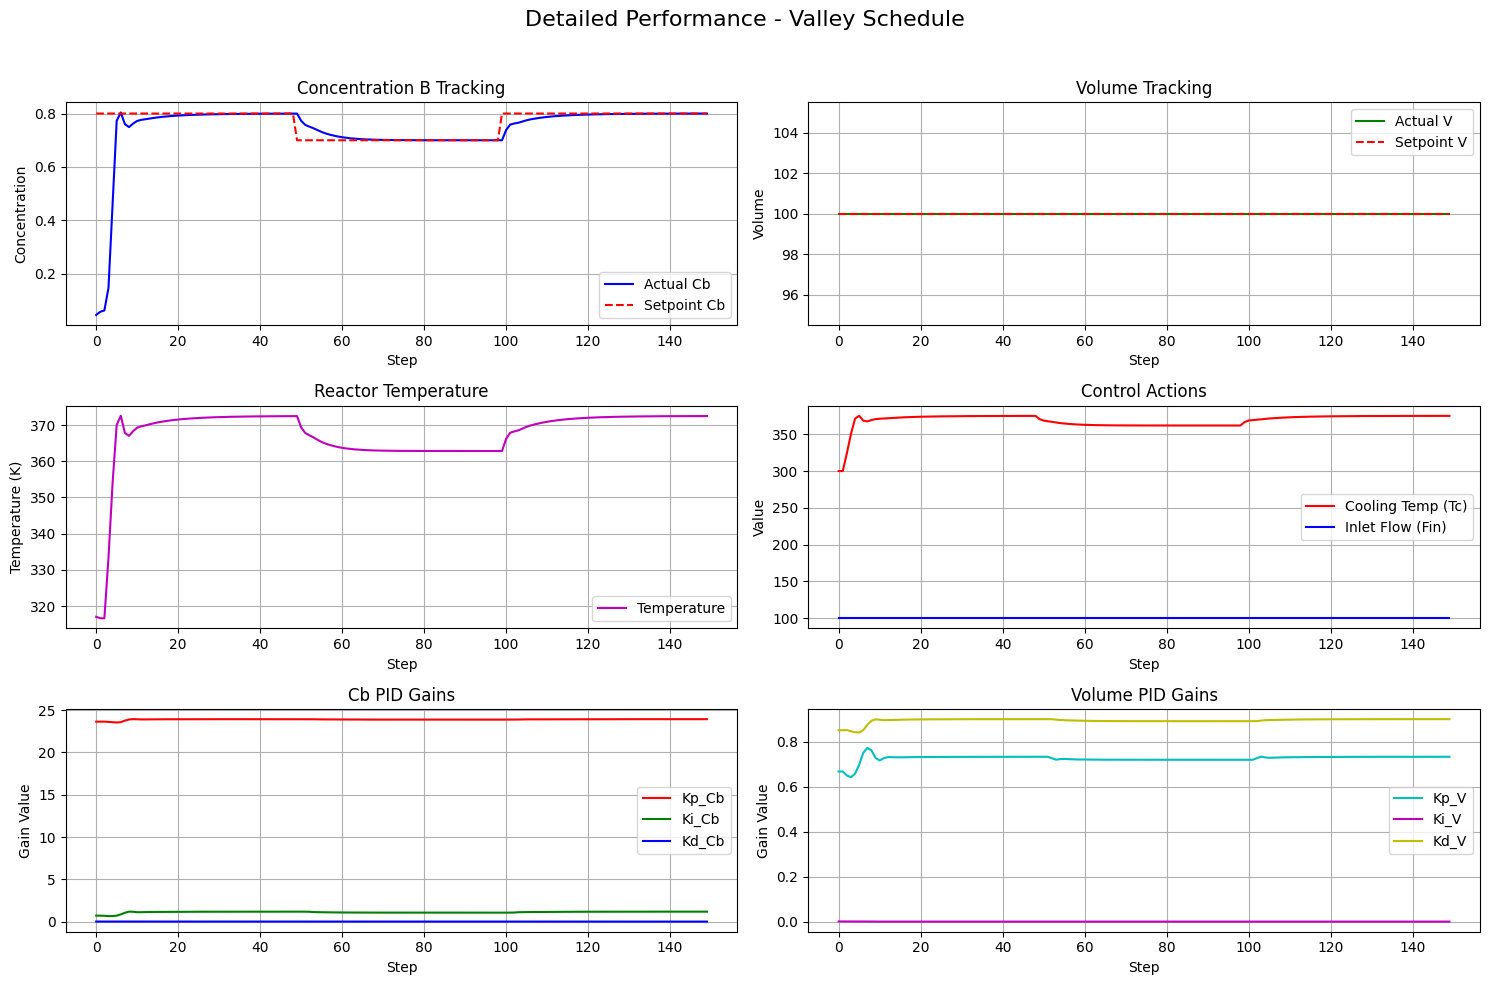

In [9]:
"""
Script to visualize CIRL policy performance on all test schedules
"""

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle

from CSTR_model_plus import CSTRRLEnv
from cirl_policy_network import CIRLPolicyNetwork

def plot_all_schedules(policy, env, save_dir=None, render=False):
    """
    Evaluate and plot policy performance on all test schedules.
    
    Args:
        policy: The trained CIRL policy
        env: CSTR environment
        save_dir: Directory to save plots (optional)
        render: Whether to render the environment during evaluation
        
    Returns:
        dict: Results for all schedules
    """
    policy.eval()  # Set to evaluation mode
    device = next(policy.parameters()).device
    
    # Set up test schedules
    test_schedules = [
        {"name": "Increasing", "setpoints": [0.6, 0.75, 0.8]},
        {"name": "Decreasing", "setpoints": [0.8, 0.75, 0.6]},
        {"name": "Peak", "setpoints": [0.7, 0.8, 0.7]},
        {"name": "Valley", "setpoints": [0.8, 0.7, 0.8]}
    ]
    
    # Create figure for all schedules
    fig, axes = plt.subplots(4, 3, figsize=(18, 16))
    fig.suptitle("CIRL Policy Performance on All Schedules", fontsize=16)
    
    # Create directory for saving plots if specified
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
    
    # Results to return
    results = {}
    
    # Run each schedule
    for idx, schedule in enumerate(test_schedules):
        schedule_name = schedule["name"]
        setpoints_Cb = schedule["setpoints"]
        print(f"Evaluating on {schedule_name} schedule: {setpoints_Cb}")
        
        # Configure environment
        setpoints_V = [100.0] * len(setpoints_Cb)
        setpoint_durations = [50] * len(setpoints_Cb)
        
        # Reset environment
        state, _ = env.reset(options={
            'setpoints_Cb': setpoints_Cb,
            'setpoints_V': setpoints_V,
            'setpoint_durations': setpoint_durations
        })
        
        # Initialize storage for trajectory
        trajectory = {
            'states': [],
            'actions': [],
            'pid_gains': [],
            'rewards': [],
            'setpoints_Cb': [],
            'setpoints_V': [],
            'Cb': [],
            'V': [],
            'T': [],
            'Tc': [],
            'Fin': []
        }
        
        # Run episode
        done = False
        total_reward = 0
        
        while not done:
            # Convert state to tensor
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            
            # Get action from policy
            with torch.no_grad():
                action = policy(state_tensor).cpu().numpy()[0]
            
            # Step the environment
            next_state, reward, done, truncated, info = env.step(action)
            
            # Extract info
            pid_gains = ((action + 1) / 2) * (env.pid_upper - env.pid_lower) + env.pid_lower
            true_state = info.get("true_state", None)
            control_action = info.get("control_action", None)
            
            # Store data
            trajectory['states'].append(state.copy())
            trajectory['actions'].append(action.copy())
            trajectory['pid_gains'].append(pid_gains.copy())
            trajectory['rewards'].append(reward)
            
            # Get current setpoints and values
            current_setpoint_Cb = next_state[9]   # Index for current setpoint Cb
            current_setpoint_V = next_state[10]   # Index for current setpoint V
            
            if true_state is not None:
                current_Cb = true_state[1]  # Index 1 is Cb
                current_V = true_state[4]   # Index 4 is V
                current_T = true_state[3]   # Index 3 is T
            else:
                # If true_state not available, use measured state
                current_Cb = next_state[0]  # Index 0 is current Cb
                current_V = next_state[2]   # Index 2 is current V
                current_T = next_state[1]   # Index 1 is current T
            
            trajectory['setpoints_Cb'].append(current_setpoint_Cb)
            trajectory['setpoints_V'].append(current_setpoint_V)
            trajectory['Cb'].append(current_Cb)
            trajectory['V'].append(current_V)
            trajectory['T'].append(current_T)
            
            if control_action is not None:
                trajectory['Tc'].append(control_action[0])
                trajectory['Fin'].append(control_action[1])
            
            # Render if requested
            if render:
                env.render()
            
            # Update state and reward
            state = next_state
            total_reward += reward
            
            if done or truncated:
                break
        
        # Calculate MSEs
        mse_cb = np.mean((np.array(trajectory['Cb']) - np.array(trajectory['setpoints_Cb'])) ** 2)
        mse_v = np.mean((np.array(trajectory['V']) - np.array(trajectory['setpoints_V'])) ** 2)
        
        print(f"  Reward: {total_reward:.2f}, MSE Cb: {mse_cb:.6f}, MSE V: {mse_v:.6f}")
        
        # Store results
        results[schedule_name] = {
            'trajectory': trajectory,
            'total_reward': total_reward,
            'mse_cb': mse_cb,
            'mse_v': mse_v
        }
        
        # Plot results for this schedule
        # Row 1: Concentration B Tracking
        axes[idx, 0].plot(trajectory['Cb'], 'b-', label='Actual Cb')
        axes[idx, 0].plot(trajectory['setpoints_Cb'], 'r--', label='Setpoint Cb')
        axes[idx, 0].set_title(f"{schedule_name} - Cb Tracking")
        axes[idx, 0].set_xlabel('Step')
        axes[idx, 0].set_ylabel('Concentration')
        axes[idx, 0].legend()
        axes[idx, 0].grid(True)
        
        # Row 2: Volume Tracking
        axes[idx, 1].plot(trajectory['V'], 'g-', label='Actual V')
        axes[idx, 1].plot(trajectory['setpoints_V'], 'r--', label='Setpoint V')
        axes[idx, 1].set_title(f"{schedule_name} - Volume Tracking")
        axes[idx, 1].set_xlabel('Step')
        axes[idx, 1].set_ylabel('Volume')
        axes[idx, 1].legend()
        axes[idx, 1].grid(True)
        
        # Row 3: PID Gains
        pid_gains = np.array(trajectory['pid_gains'])
        axes[idx, 2].plot(pid_gains[:, 0], 'r-', label='Kp_Cb')
        axes[idx, 2].plot(pid_gains[:, 1], 'g-', label='Ki_Cb')
        axes[idx, 2].plot(pid_gains[:, 2], 'b-', label='Kd_Cb')
        axes[idx, 2].plot(pid_gains[:, 3], 'c-', label='Kp_V')
        axes[idx, 2].plot(pid_gains[:, 4], 'm-', label='Ki_V')
        axes[idx, 2].plot(pid_gains[:, 5], 'y-', label='Kd_V')
        axes[idx, 2].set_title(f"{schedule_name} - PID Gains")
        axes[idx, 2].set_xlabel('Step')
        axes[idx, 2].set_ylabel('Gain Value')
        axes[idx, 2].legend()
        axes[idx, 2].grid(True)
    
    # Add metrics to the plot as text
    metrics_text = "Performance Metrics:\n"
    for schedule_name, schedule_results in results.items():
        metrics_text += f"\n{schedule_name}:\n"
        metrics_text += f"  Reward: {schedule_results['total_reward']:.2f}\n"
        metrics_text += f"  MSE Cb: {schedule_results['mse_cb']:.6f}\n"
        metrics_text += f"  MSE V: {schedule_results['mse_v']:.6f}\n"
    
    # Make room for text
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the bottom margin
    
    # Save figure if directory is specified
    if save_dir:
        plt.savefig(os.path.join(save_dir, "all_schedules_performance.png"), dpi=300)
    
    # Show plot
    plt.show()
    
    # Also create a separate detailed plot for each schedule
    for schedule_name, schedule_results in results.items():
        trajectory = schedule_results['trajectory']
        
        # Create detailed figure
        fig, axes = plt.subplots(3, 2, figsize=(15, 10))
        fig.suptitle(f"Detailed Performance - {schedule_name} Schedule", fontsize=16)
        
        # Plot Cb tracking
        axes[0, 0].plot(trajectory['Cb'], 'b-', label='Actual Cb')
        axes[0, 0].plot(trajectory['setpoints_Cb'], 'r--', label='Setpoint Cb')
        axes[0, 0].set_title('Concentration B Tracking')
        axes[0, 0].set_xlabel('Step')
        axes[0, 0].set_ylabel('Concentration')
        axes[0, 0].legend()
        axes[0, 0].grid(True)
        
        # Plot Volume tracking
        axes[0, 1].plot(trajectory['V'], 'g-', label='Actual V')
        axes[0, 1].plot(trajectory['setpoints_V'], 'r--', label='Setpoint V')
        axes[0, 1].set_title('Volume Tracking')
        axes[0, 1].set_xlabel('Step')
        axes[0, 1].set_ylabel('Volume')
        axes[0, 1].legend()
        axes[0, 1].grid(True)
        
        # Plot temperature
        axes[1, 0].plot(trajectory['T'], 'm-', label='Temperature')
        axes[1, 0].set_title('Reactor Temperature')
        axes[1, 0].set_xlabel('Step')
        axes[1, 0].set_ylabel('Temperature (K)')
        axes[1, 0].legend()
        axes[1, 0].grid(True)
        
        # Plot control actions if available
        if 'Tc' in trajectory and len(trajectory['Tc']) > 0:
            axes[1, 1].plot(trajectory['Tc'], 'r-', label='Cooling Temp (Tc)')
            axes[1, 1].plot(trajectory['Fin'], 'b-', label='Inlet Flow (Fin)')
            axes[1, 1].set_title('Control Actions')
            axes[1, 1].set_xlabel('Step')
            axes[1, 1].set_ylabel('Value')
            axes[1, 1].legend()
            axes[1, 1].grid(True)
        
        # Plot PID gains
        pid_gains = np.array(trajectory['pid_gains'])
        
        # Split PID gains into two plots for better visibility
        axes[2, 0].plot(pid_gains[:, 0], 'r-', label='Kp_Cb')
        axes[2, 0].plot(pid_gains[:, 1], 'g-', label='Ki_Cb')
        axes[2, 0].plot(pid_gains[:, 2], 'b-', label='Kd_Cb')
        axes[2, 0].set_title('Cb PID Gains')
        axes[2, 0].set_xlabel('Step')
        axes[2, 0].set_ylabel('Gain Value')
        axes[2, 0].legend()
        axes[2, 0].grid(True)
        
        axes[2, 1].plot(pid_gains[:, 3], 'c-', label='Kp_V')
        axes[2, 1].plot(pid_gains[:, 4], 'm-', label='Ki_V')
        axes[2, 1].plot(pid_gains[:, 5], 'y-', label='Kd_V')
        axes[2, 1].set_title('Volume PID Gains')
        axes[2, 1].set_xlabel('Step')
        axes[2, 1].set_ylabel('Gain Value')
        axes[2, 1].legend()
        axes[2, 1].grid(True)
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        
        # Save detailed figure if directory is specified
        if save_dir:
            plt.savefig(os.path.join(save_dir, f"{schedule_name}_detailed_performance.png"), dpi=300)
        
        plt.show()
    
    return results

# Example usage
if __name__ == "__main__":
    # Create environment
    env = CSTRRLEnv(
        simulation_steps=150,
        dt=1.0,
        uncertainty_level=0.0,
        noise_level=0.0,
        actuator_delay_steps=0,
        transport_delay_steps=0,
        enable_disturbances=False
    )
    
    # Load trained policy
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    policy = CIRLPolicyNetwork(state_dim=env.observation_space.shape[0], hidden_dims=[64, 64]).to(device)
    policy.load("./results/CIRL/models/cirl_policy_final.pt")
    
    # Run evaluation and plotting
    results = plot_all_schedules(policy, env, save_dir="./results/test_plots")

Analyzing PID gains for Increasing schedule: [0.6, 0.75, 0.8]
Analyzing PID gains for Decreasing schedule: [0.8, 0.75, 0.6]
Analyzing PID gains for Peak schedule: [0.7, 0.8, 0.7]
Analyzing PID gains for Valley schedule: [0.8, 0.7, 0.8]


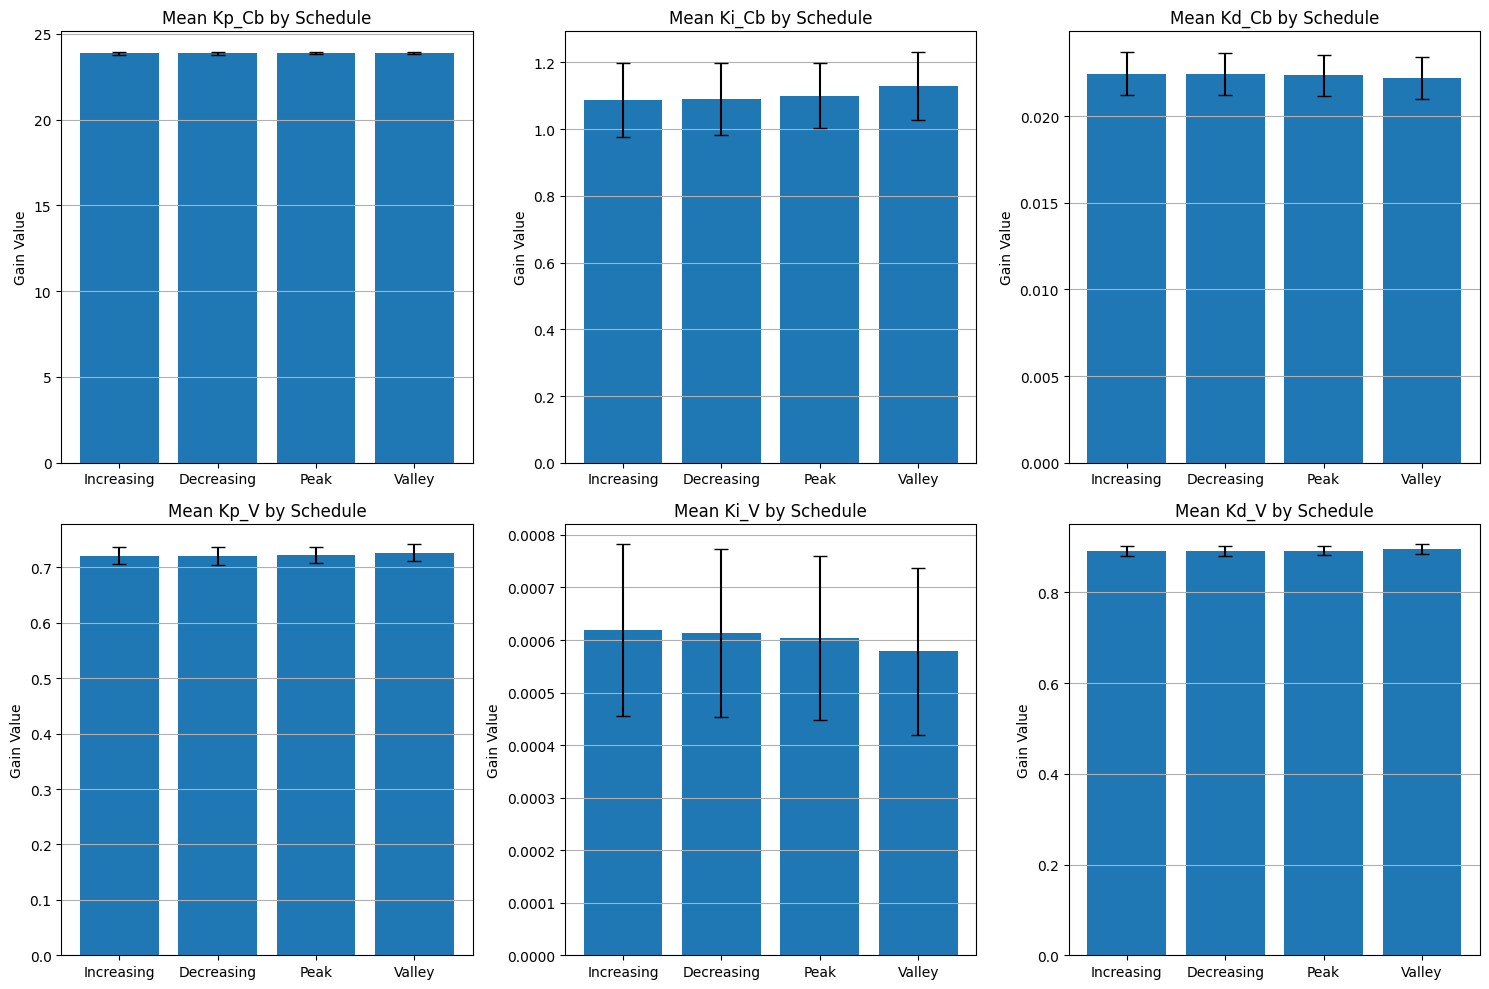

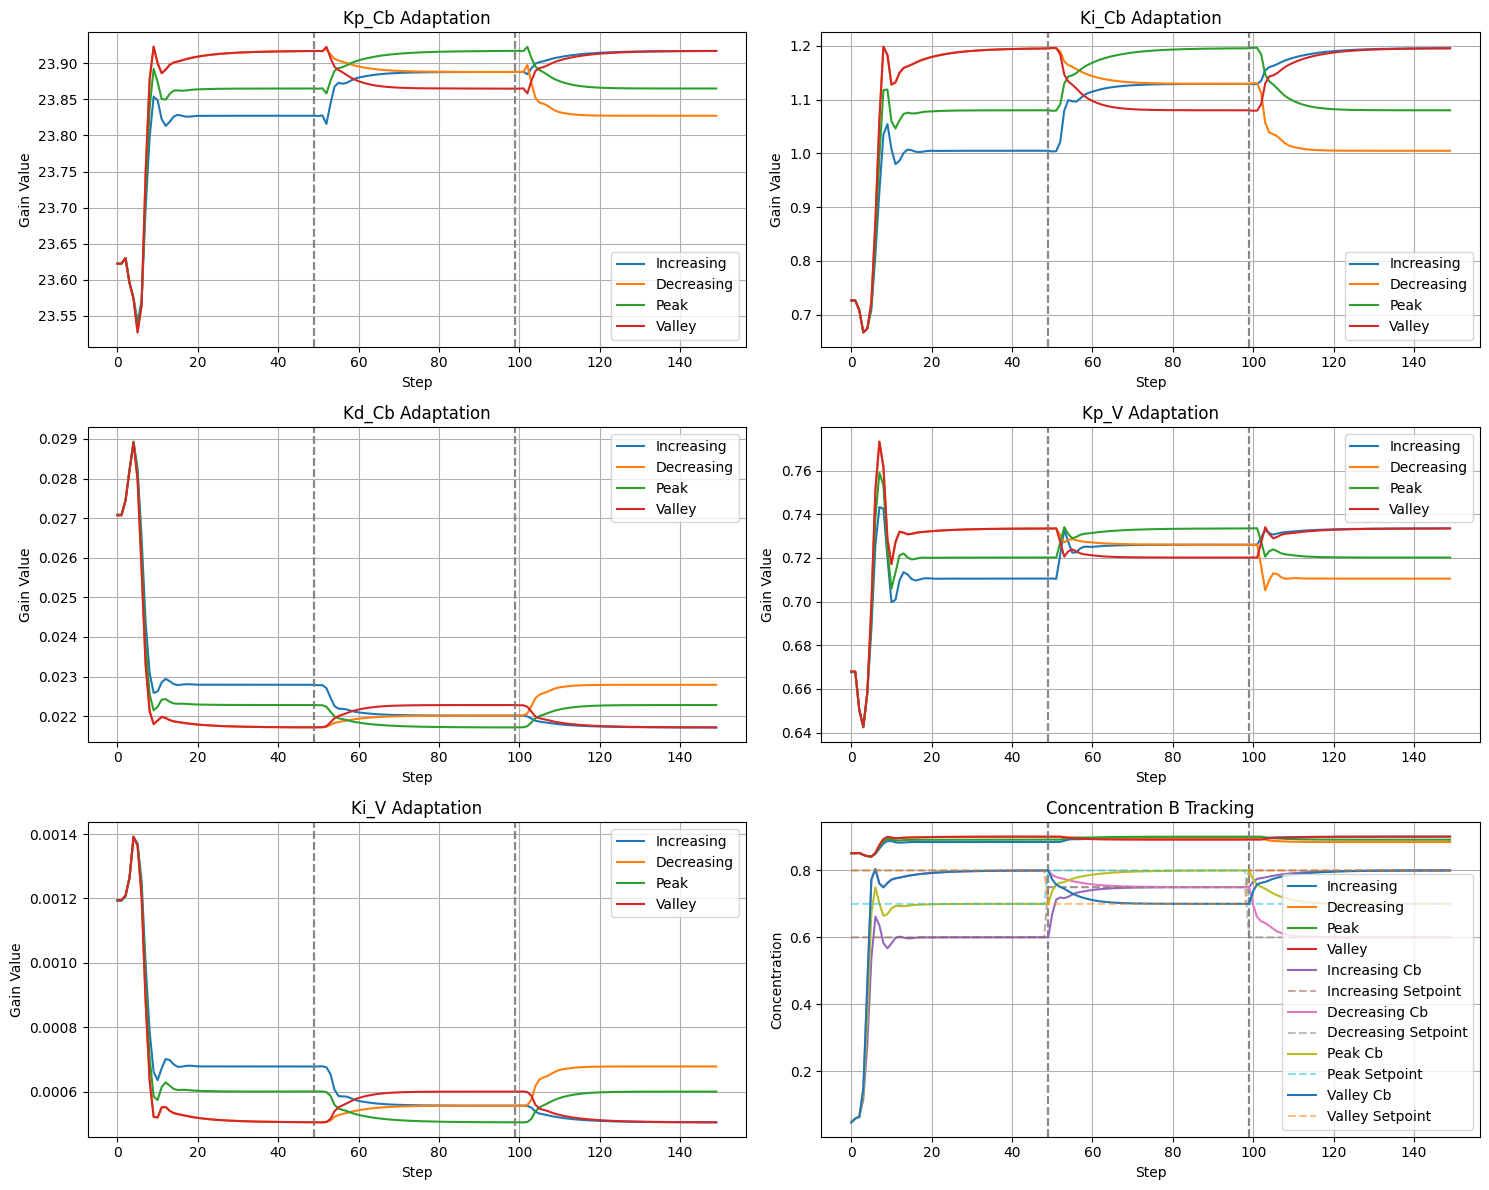

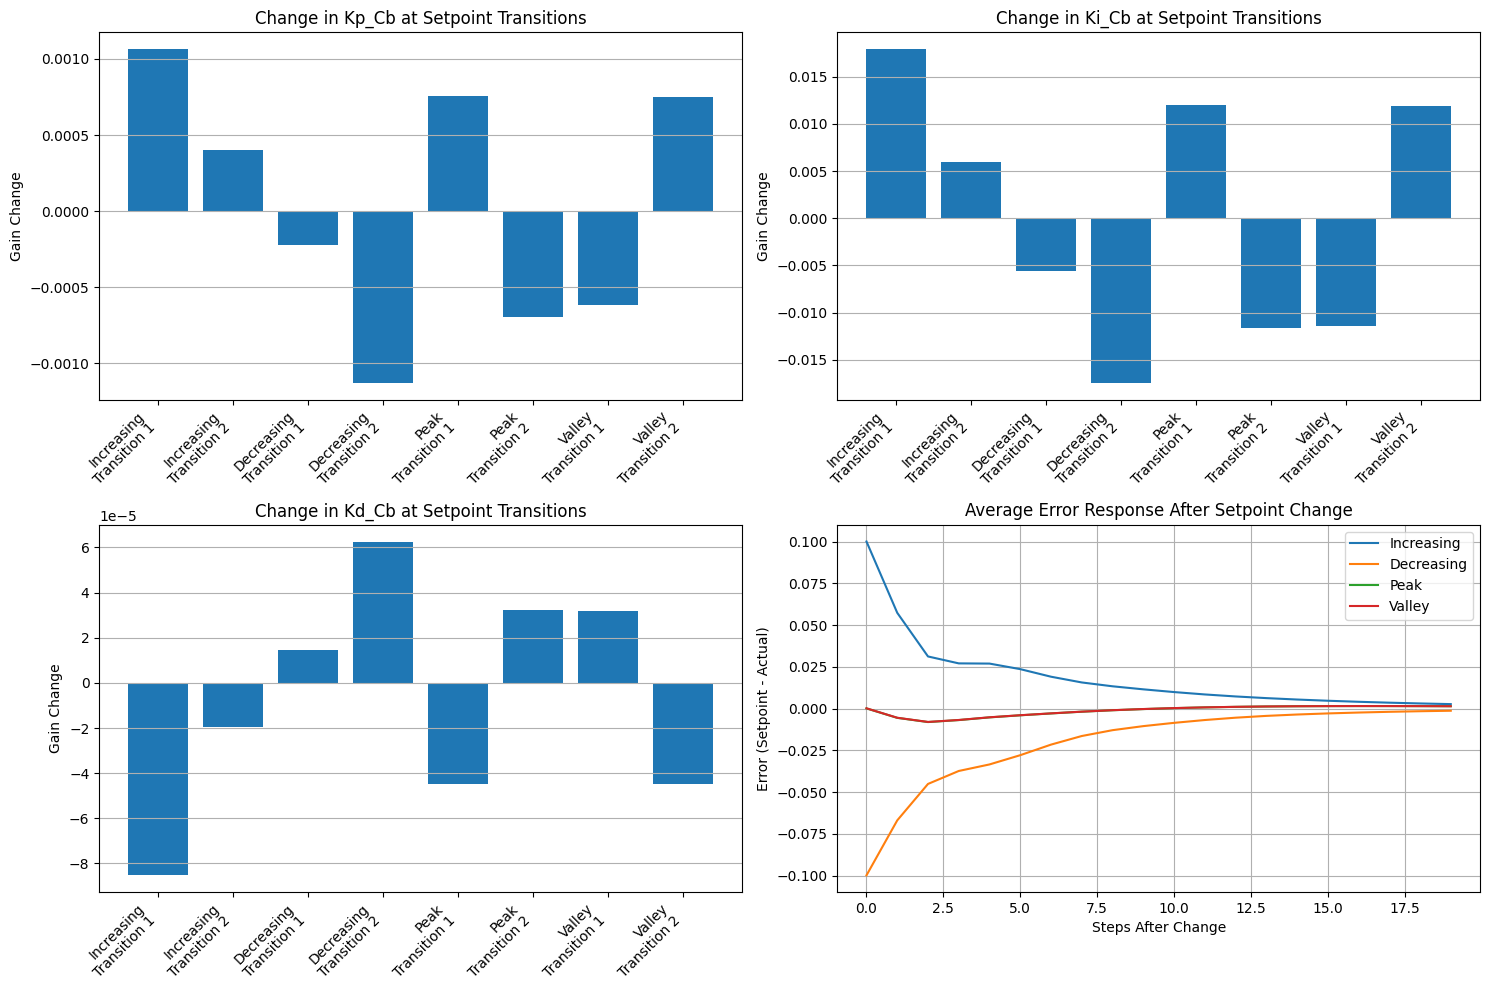

In [11]:
"""
Script to analyze and compare PID gains across different setpoint schedules
"""

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle

from CSTR_model_plus import CSTRRLEnv
from cirl_policy_network import CIRLPolicyNetwork

def analyze_pid_gain_patterns(policy, env, save_dir=None):
    """
    Analyze how PID gains adapt to different setpoint schedules.
    
    Args:
        policy: The trained CIRL policy
        env: CSTR environment
        save_dir: Directory to save plots (optional)
        
    Returns:
        dict: Analysis results
    """
    policy.eval()  # Set to evaluation mode
    device = next(policy.parameters()).device
    
    # Set up test schedules
    test_schedules = [
        {"name": "Increasing", "setpoints": [0.6, 0.75, 0.8]},
        {"name": "Decreasing", "setpoints": [0.8, 0.75, 0.6]},
        {"name": "Peak", "setpoints": [0.7, 0.8, 0.7]},
        {"name": "Valley", "setpoints": [0.8, 0.7, 0.8]}
    ]
    
    # Parameters to store gain transitions at setpoint changes
    setpoint_transitions = {}
    setpoint_response = {}
    gain_statistics = {}
    trajectories = {}
    
    # Create directory for saving plots if specified
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
    
    # Run each schedule
    for schedule in test_schedules:
        schedule_name = schedule["name"]
        setpoints_Cb = schedule["setpoints"]
        print(f"Analyzing PID gains for {schedule_name} schedule: {setpoints_Cb}")
        
        # Configure environment
        setpoints_V = [100.0] * len(setpoints_Cb)
        setpoint_durations = [50] * len(setpoints_Cb)
        
        # Reset environment
        state, _ = env.reset(options={
            'setpoints_Cb': setpoints_Cb,
            'setpoints_V': setpoints_V,
            'setpoint_durations': setpoint_durations
        })
        
        # Storage for trajectory
        trajectory = {
            'pid_gains': [],
            'setpoints_Cb': [],
            'Cb': [],
            'error_Cb': [],
            'setpoint_change_indices': []
        }
        
        # Run episode
        done = False
        step = 0
        last_setpoint = None
        
        while not done:
            # Convert state to tensor
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            
            # Get action from policy
            with torch.no_grad():
                action = policy(state_tensor).cpu().numpy()[0]
            
            # Step the environment
            next_state, reward, done, truncated, info = env.step(action)
            
            # Calculate PID gains from normalized action
            pid_gains = ((action + 1) / 2) * (env.pid_upper - env.pid_lower) + env.pid_lower
            
            # Get current values
            current_setpoint_Cb = next_state[9]  # Setpoint Cb
            true_state = info.get("true_state", None)
            
            if true_state is not None:
                current_Cb = true_state[1]  # Actual Cb
            else:
                current_Cb = next_state[0]  # Use measured state if true state unavailable
            
            # Calculate error
            error_Cb = current_setpoint_Cb - current_Cb
            
            # Check for setpoint change
            if last_setpoint is not None and current_setpoint_Cb != last_setpoint:
                trajectory['setpoint_change_indices'].append(step)
            
            last_setpoint = current_setpoint_Cb
            
            # Store data
            trajectory['pid_gains'].append(pid_gains)
            trajectory['setpoints_Cb'].append(current_setpoint_Cb)
            trajectory['Cb'].append(current_Cb)
            trajectory['error_Cb'].append(error_Cb)
            
            # Update state
            state = next_state
            step += 1
            
            if done or truncated:
                break
        
        # Convert lists to numpy arrays for easier analysis
        trajectory['pid_gains'] = np.array(trajectory['pid_gains'])
        trajectory['setpoints_Cb'] = np.array(trajectory['setpoints_Cb'])
        trajectory['Cb'] = np.array(trajectory['Cb'])
        trajectory['error_Cb'] = np.array(trajectory['error_Cb'])
        
        # Store the trajectory
        trajectories[schedule_name] = trajectory
        
        # Analyze gain patterns around setpoint changes
        transitions = []
        responses = []
        
        for idx in trajectory['setpoint_change_indices']:
            # Get gains just before and after setpoint change
            before_gains = trajectory['pid_gains'][max(0, idx-5):idx].mean(axis=0)
            after_gains = trajectory['pid_gains'][idx:min(len(trajectory['pid_gains']), idx+5)].mean(axis=0)
            
            # Store transition
            transitions.append({
                'before': before_gains,
                'after': after_gains,
                'change': after_gains - before_gains
            })
            
            # Analyze response after setpoint change
            response_window = min(20, len(trajectory['Cb']) - idx)
            if response_window > 0:
                error_response = trajectory['error_Cb'][idx:idx+response_window]
                responses.append({
                    'error_profile': error_response,
                    'settling_time': np.argmin(np.abs(error_response)) if len(error_response) > 0 else None,
                    'max_error': np.max(np.abs(error_response)) if len(error_response) > 0 else None
                })
        
        setpoint_transitions[schedule_name] = transitions
        setpoint_response[schedule_name] = responses
        
        # Calculate gain statistics for this schedule
        gain_statistics[schedule_name] = {
            'mean': trajectory['pid_gains'].mean(axis=0),
            'std': trajectory['pid_gains'].std(axis=0),
            'min': trajectory['pid_gains'].min(axis=0),
            'max': trajectory['pid_gains'].max(axis=0),
            'range': trajectory['pid_gains'].max(axis=0) - trajectory['pid_gains'].min(axis=0)
        }
    
    # Create comparative plots
    
    # 1. Overall PID gain statistics by schedule
    gain_names = ['Kp_Cb', 'Ki_Cb', 'Kd_Cb', 'Kp_V', 'Ki_V', 'Kd_V']
    
    # Plot mean gains for each schedule
    plt.figure(figsize=(15, 10))
    
    for i, gain_name in enumerate(gain_names):
        plt.subplot(2, 3, i+1)
        
        # Collect data for this gain across schedules
        schedules = list(gain_statistics.keys())
        mean_values = [gain_statistics[s]['mean'][i] for s in schedules]
        std_values = [gain_statistics[s]['std'][i] for s in schedules]
        
        # Create bar chart with error bars
        plt.bar(schedules, mean_values, yerr=std_values, capsize=5)
        plt.title(f'Mean {gain_name} by Schedule')
        plt.ylabel('Gain Value')
        plt.grid(axis='y')
    
    plt.tight_layout()
    if save_dir:
        plt.savefig(os.path.join(save_dir, "pid_gain_statistics.png"), dpi=300)
    plt.show()
    
    # 2. Plot gain adaptations over time for each schedule on one figure
    plt.figure(figsize=(15, 12))
    
    for i, gain_name in enumerate(gain_names):
        plt.subplot(3, 2, i+1)
        
        for schedule_name, trajectory in trajectories.items():
            # Plot this gain over time
            plt.plot(trajectory['pid_gains'][:, i], label=schedule_name)
            
            # Mark setpoint changes
            for idx in trajectory['setpoint_change_indices']:
                plt.axvline(x=idx, color='gray', linestyle='--', alpha=0.5)
        
        plt.title(f'{gain_name} Adaptation')
        plt.xlabel('Step')
        plt.ylabel('Gain Value')
        plt.legend()
        plt.grid(True)
    
    # Add a subplot for Cb tracking (average across schedules)
    plt.subplot(3, 2, 6)
    
    for schedule_name, trajectory in trajectories.items():
        plt.plot(trajectory['Cb'], label=f"{schedule_name} Cb")
        plt.plot(trajectory['setpoints_Cb'], '--', label=f"{schedule_name} Setpoint", alpha=0.5)
    
    plt.title('Concentration B Tracking')
    plt.xlabel('Step')
    plt.ylabel('Concentration')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    if save_dir:
        plt.savefig(os.path.join(save_dir, "pid_gain_adaptations.png"), dpi=300)
    plt.show()
    
    # 3. Compare gain changes at setpoint transitions
    # Extract transitions for the Cb controller gains
    cb_gains_indices = [0, 1, 2]  # Kp_Cb, Ki_Cb, Kd_Cb
    
    plt.figure(figsize=(15, 10))
    
    for i, idx in enumerate(cb_gains_indices):
        plt.subplot(2, 2, i+1)
        
        # For each schedule, plot the changes in this gain at setpoint transitions
        x_positions = []
        y_values = []
        labels = []
        
        position = 0
        for schedule_name, transitions in setpoint_transitions.items():
            for j, transition in enumerate(transitions):
                x_positions.append(position)
                y_values.append(transition['change'][idx])
                labels.append(f"{schedule_name}\nTransition {j+1}")
                position += 1
        
        plt.bar(x_positions, y_values)
        plt.xticks(x_positions, labels, rotation=45, ha='right')
        plt.title(f'Change in {gain_names[idx]} at Setpoint Transitions')
        plt.ylabel('Gain Change')
        plt.grid(axis='y')
    
    # Add a subplot for error response
    plt.subplot(2, 2, 4)
    
    # For each schedule, plot average error profile after setpoint change
    for schedule_name, responses in setpoint_response.items():
        # Collect all error profiles
        error_profiles = []
        for response in responses:
            if response['error_profile'] is not None and len(response['error_profile']) > 0:
                error_profiles.append(response['error_profile'])
        
        # If we have profiles, plot the average
        if error_profiles:
            # Find the maximum length
            max_len = max(len(profile) for profile in error_profiles)
            
            # Pad shorter profiles with NaN
            padded_profiles = []
            for profile in error_profiles:
                padded = np.full(max_len, np.nan)
                padded[:len(profile)] = profile
                padded_profiles.append(padded)
            
            # Calculate mean error profile, ignoring NaN values
            mean_profile = np.nanmean(padded_profiles, axis=0)
            
            # Plot mean error profile
            plt.plot(mean_profile, label=schedule_name)
    
    plt.title('Average Error Response After Setpoint Change')
    plt.xlabel('Steps After Change')
    plt.ylabel('Error (Setpoint - Actual)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    if save_dir:
        plt.savefig(os.path.join(save_dir, "pid_gain_transitions.png"), dpi=300)
    plt.show()
    
    # Return analysis results
    results = {
        'trajectories': trajectories,
        'gain_statistics': gain_statistics,
        'setpoint_transitions': setpoint_transitions,
        'setpoint_response': setpoint_response
    }
    
    return results

# Example usage
if __name__ == "__main__":
    # Create environment
    env = CSTRRLEnv(
        simulation_steps=150,
        dt=1.0,
        uncertainty_level=0.0,
        noise_level=0.0,
        actuator_delay_steps=0,
        transport_delay_steps=0,
        enable_disturbances=False
    )
    
    # Load trained policy
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    policy = CIRLPolicyNetwork(state_dim=env.observation_space.shape[0], hidden_dims=[64, 64]).to(device)
    policy.load("./results/CIRL/models/cirl_policy_final.pt")
    
    # Run PID gain analysis
    analysis_results = analyze_pid_gain_patterns(policy, env, save_dir="./results/test_plots")